# DQN class

In [271]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

In [272]:
class Net(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_states, n_hidden)
        self.out = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        actions_value = self.out(x)
        return actions_value

In [273]:
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity):
        self.eval_net, self.target_net = Net(n_states, n_actions, n_hidden), Net(n_states, n_actions, n_hidden)

        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # 每個 memory 中的 experience 大小為 (state + next state + reward + action)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.memory_counter = 0
        self.learn_step_counter = 0 # 讓 target network 知道什麼時候要更新

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.target_replace_iter = target_replace_iter
        self.memory_capacity = memory_capacity

    def choose_action(self, state, explore = True):
        x = torch.unsqueeze(torch.FloatTensor(state), 0)

        # epsilon-greedy
        if np.random.uniform() < self.epsilon and explore: # 隨機
            action = np.random.randint(0, self.n_actions)
            return action, 1
        else: # 根據現有 policy 做最好的選擇
            actions_value = self.eval_net(x) # 以現有 eval net 得出各個 action 的分數
            action = torch.max(actions_value, 1)[1].data.numpy()[0] # 挑選最高分的 action
            return action, 0

    def store_transition(self, state, action, reward, next_state):
        # 打包 experience
        transition = np.hstack((state, [action, reward], next_state))

        # 存進 memory；舊 memory 可能會被覆蓋
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # 隨機取樣 batch_size 個 experience
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        b_memory = self.memory[sample_index, :]
        b_state = torch.FloatTensor(b_memory[:, :self.n_states])
        b_action = torch.LongTensor(b_memory[:, self.n_states:self.n_states+1].astype(int))
        b_reward = torch.FloatTensor(b_memory[:, self.n_states+1:self.n_states+2])
        b_next_state = torch.FloatTensor(b_memory[:, -self.n_states:])

        # 計算現有 eval net 和 target net 得出 Q value 的落差
        q_eval = self.eval_net(b_state).gather(1, b_action) # 重新計算這些 experience 當下 eval net 所得出的 Q value
        q_next = self.target_net(b_next_state).detach() # detach 才不會訓練到 target net
        q_target = b_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1) # 計算這些 experience 當下 target net 所得出的 Q value
        loss = self.loss_func(q_eval, q_target)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每隔一段時間 (target_replace_iter), 更新 target net，即複製 eval net 到 target net
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

# GYM example (pole balancing by dqn)

In [4]:
env = gym.make('CartPole-v0')
#env = env.unwrapped 

# Environment parameters
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

# Hyper parameters
n_hidden = 50
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100 # target network 更新間隔
memory_capacity = 2000
n_episodes = 400

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

s = torch.FloatTensor([[1,1,1,1], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
a = torch.LongTensor([[0], [1], [1], [0]])
print(dqn.eval_net(s).gather(1, a))
print(dqn.eval_net(s))
print(dqn.target_net(s).detach())
print(dqn.target_net(s))

q_next = dqn.target_net(s).detach()
print(q_next.max(1)[0])
print(q_next.max(1)[0].view(4, 1))
q_eval = dqn.eval_net(s).gather(1, a)
q_target = q_next.max(1)[0].view(4, 1)
print(dqn.loss_func(q_eval, q_target))
print(dqn.optimizer.zero_grad())
print(dqn.loss_func(q_eval, q_target).backward())
print(dqn.optimizer.step())
print(dqn.eval_net(s).gather(1, a))
print(q_next.max(1)[0].view(4, 1))
q_eval = dqn.eval_net(s).gather(1, a)
print(dqn.loss_func(q_eval, q_target))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
tensor([[ 0.2148],
        [-0.0147],
        [-0.0147],
        [-0.0629]], grad_fn=<GatherBackward>)
tensor([[ 0.2148, -0.2850],
        [-0.0629, -0.0147],
        [-0.0629, -0.0147],
        [-0.0629, -0.0147]], grad_fn=<ThAddmmBackward>)
tensor([[-0.1469,  0.0837],
        [-0.0484, -0.0496],
        [-0.0484, -0.0496],
        [-0.0484, -0.0496]])
tensor([[-0.1469,  0.0837],
        [-0.0484, -0.0496],
        [-0.0484, -0.0496],
        [-0.0484, -0.0496]], grad_fn=<ThAddmmBackward>)
tensor([ 0.0837, -0.0484, -0.0484, -0.0484])
tensor([[ 0.0837],
        [-0.0484],
        [-0.0484],
        [-0.0484]])
tensor(0.0049, grad_fn=<MseLossBackward>)
None
None
None
tensor([[-0.0390],
        [-0.1006],
        [-0.1006],
        [-0.1096]], grad_fn=<GatherBackward>)
tensor([[ 0.0837],
        [-0.0484],
        [-0.0484],
        [-0.0484]])
tensor(0.0061, grad_fn=<MseLossBackward>)


In [276]:
env = gym.make('CartPole-v0')
env = env.unwrapped 

# Environment parameters
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

# Hyper parameters
n_hidden = 50
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100 # target network 更新間隔
memory_capacity = 2000
n_episodes = 400

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for i_episode in range(n_episodes):
    t = 0
    rewards = 0
    state = env.reset()
    while True:
        #env.render()

        # 選擇 action
        action = dqn.choose_action(state)[0]
        next_state, reward, done, info = env.step(action)
        
        
        # 累積 reward
        x, x_dot, theta, theta_dot = next_state
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2
        
        # 儲存 experience
        dqn.store_transition(state, action, reward, next_state)

        # 有足夠 experience 後進行訓練
        if dqn.memory_counter > memory_capacity:
            dqn.learn()

        # 進入下一 state
        state = next_state

        if done and dqn.memory_counter > memory_capacity:
            print('Episode finished after {} timesteps'.format(t+1))
            break

        t += 1

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
Episode finished after 2001 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 13 timesteps
Episode finished after 12 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 12 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finish

Episode finished after 68 timesteps
Episode finished after 47 timesteps
Episode finished after 65 timesteps
Episode finished after 36 timesteps
Episode finished after 62 timesteps
Episode finished after 71 timesteps
Episode finished after 71 timesteps
Episode finished after 103 timesteps
Episode finished after 142 timesteps
Episode finished after 52 timesteps
Episode finished after 47 timesteps
Episode finished after 49 timesteps
Episode finished after 47 timesteps
Episode finished after 342 timesteps
Episode finished after 68 timesteps
Episode finished after 199 timesteps
Episode finished after 166 timesteps
Episode finished after 8130 timesteps
Episode finished after 364 timesteps
Episode finished after 74 timesteps
Episode finished after 144 timesteps
Episode finished after 474 timesteps
Episode finished after 271 timesteps
Episode finished after 74 timesteps
Episode finished after 47 timesteps
Episode finished after 194 timesteps
Episode finished after 257 timesteps


KeyboardInterrupt: 

# DPG class

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
import gym
import pdb

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden1, n_hidden2):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(n_states, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [3]:
class DPG(object):
    def __init__(self, n_states, n_actions, n_hidden1, n_hidden2, lr, gamma):
        self.policy_net = PolicyNet(n_states, n_actions, n_hidden1, n_hidden2)
        self.optimizer = torch.optim.RMSprop(self.policy_net.parameters(), lr=lr)
        
        self.state_pool = []
        self.action_pool = []
        self.reward_pool = []

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        
        self.lr = lr
        self.gamma = gamma

    def choose_action(self, state):
        #x = torch.unsqueeze(torch.FloatTensor(state), 0)
        x = Variable(torch.from_numpy(state).float())
        probs = self.policy_net(x)
        m = Bernoulli(probs)
        action = m.sample()
        action = action.data.numpy().astype(int)[0][0]
        return action

    def store_transition(self, state, action, reward):
        self.state_pool.append(Variable(torch.from_numpy(state).float()))
        self.action_pool.append(float(action))
        self.reward_pool.append(reward)

    def learn(self):
        
        # Discount reward
        running_add = 0
        for i in reversed(range(len(self.reward_pool))):
            if self.reward_pool[i] == 0:
                running_add = 0
            else:
                running_add = running_add * self.gamma + self.reward_pool[i]
                self.reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(self.reward_pool)
        reward_std = np.std(self.reward_pool)
        for i in range(len(self.reward_pool)):
            self.reward_pool[i] = (self.reward_pool[i] - reward_mean) / reward_std

        
        # Gradient Desent
        self.optimizer.zero_grad()
        
        for i in range(len(self.reward_pool)):
            state = self.state_pool[i]
            action = Variable(torch.FloatTensor([self.action_pool[i]]))
            reward = self.reward_pool[i]

            probs = self.policy_net(state)
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward
            loss.backward()

        self.optimizer.step()

        self.state_pool = []
        self.action_pool = []
        self.reward_pool = []

In [18]:
class DPGm(object):
    def __init__(self, n_states, n_actions, n_hidden1, n_hidden2, lr, gamma):
        self.policy_net = PolicyNet(n_states, n_actions, n_hidden1, n_hidden2)
        self.optimizer = torch.optim.RMSprop(self.policy_net.parameters(), lr=lr)
        
        self.state_pool = []
        self.action_pool = []
        self.reward_pool = []

        self.n_states = n_states
        self.n_actions = n_actions
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        
        self.lr = lr
        self.gamma = gamma

    def choose_action(self, state):
        x = torch.unsqueeze(torch.FloatTensor(state), 0)[0]
        probs = self.policy_net(x)
        m = Bernoulli(probs)
        action = m.sample()
        return list(action.data.numpy().astype(int))

    def store_transition(self, state, action, reward):
        self.state_pool.append(torch.unsqueeze(torch.FloatTensor(state), 0)[0])
        self.action_pool.append(action)
        self.reward_pool.append(reward)

    def learn(self):
        
        # Gradient Desent
        self.optimizer.zero_grad()
        
        for i in range(len(self.reward_pool)):
            state = self.state_pool[i]
            action = self.action_pool[i]
            reward = self.reward_pool[i]
            
            probs = self.policy_net(state)
            losslist = []
            for i in range(0, len(action)):
                m = Bernoulli(probs[i:i+1])
                losslist.append(abs(m.log_prob(Variable(torch.FloatTensor([action[i]]))).item()))
            
            upa = np.argmax(losslist)
            m = Bernoulli(probs[upa:upa+1])
            loss = -m.log_prob(Variable(torch.FloatTensor([action[upa]])))
            loss.backward(retain_graph=True)

        self.optimizer.step()

        self.state_pool = []
        self.action_pool = []
        self.reward_pool = []

In [17]:
pn = PolicyNet(4, 4, 24, 36)
env = gym.make('CartPole-v0')
state = env.reset()
x = Variable(torch.from_numpy(state).float())
probs = pn(x)

ll = []
m = Bernoulli(probs[:1])
loss = -m.log_prob(action[0])
for i in range(1, len(action)):
    m = Bernoulli(probs[i:i+1])
    loss += -m.log_prob(action[i])
loss.item()
np.argmax([1,2,3])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


2

In [193]:
pn = PolicyNet(4, 4, 24, 36)
env = gym.make('CartPole-v0')
state = env.reset()
x = Variable(torch.from_numpy(state).float())
probs = pn(x)
m = Bernoulli(probs)
action = m.sample()
loss = -m.log_prob(action)
#loss.backward()
loss

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


tensor([0.6799, 0.6847, 0.7536, 0.6705], grad_fn=<NegBackward>)

# GYM example (pole balancing by dpg)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


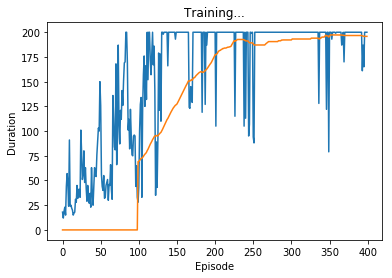

In [23]:
dpg = DPG(4, 1, 24, 36, 0.01, 0.99)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        plt.show()

    plt.pause(0.001)  # pause a bit so that plots are updated
        
# Parameters
num_episode = 400
batch_size = 5

env = gym.make('CartPole-v0')

steps = 0

for e in range(num_episode):

    state = env.reset()

    for t in count():
        action = dpg.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        # To mark boundarys between episodes
        if done:
            reward = 0
        
        dpg.store_transition(state, action, reward)

        state = next_state
        
        if done:
            episode_durations.append(t + 1)
            break

    # Update policy
    if e > 0 and e % batch_size == 0:
        dpg.learn()

plot_durations()

# DPG class (TensorFlow)

In [15]:
import numpy as np
import tensorflow as tf

# reproducible
np.random.seed(1)
tf.set_random_seed(1)


class PolicyGradient:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.95,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []

        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # http://0.0.0.0:6006/
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):
        tf.reset_default_graph()
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32, [None, self.n_features], name="observations")
            self.tf_acts = tf.placeholder(tf.int32, [None, ], name="actions_num")
            self.tf_vt = tf.placeholder(tf.float32, [None, ], name="actions_value")
        # fc1
        layer = tf.layers.dense(
            inputs=self.tf_obs,
            units=10,
            activation=tf.nn.relu,  # tanh activation
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc1'
        )
        # fc2
        all_act = tf.layers.dense(
            inputs=layer,
            units=self.n_actions,
            activation=None,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc2'
        )

        self.all_act_prob = tf.nn.softmax(all_act, name='act_prob')  # use softmax to convert to probability

        with tf.name_scope('loss'):
            # to maximize total reward (log_p * R) is to minimize -(log_p * R), and the tf only have minimize(loss)
            neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_act, labels=self.tf_acts)   # this is negative log of chosen action
            # or in this way:
            # neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob)*tf.one_hot(self.tf_acts, self.n_actions), axis=1)
            loss = tf.reduce_mean(neg_log_prob * self.tf_vt)  # reward guided loss

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

    def choose_action(self, observation):
        prob_weights = self.sess.run(self.all_act_prob, feed_dict={self.tf_obs: observation[np.newaxis, :]})
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel())  # select action w.r.t the actions prob
        return action
        '''
        if np.random.uniform() < 0.1:
            return np.random.choice(range(prob_weights.shape[1]))
        else:
            return np.argmax(prob_weights)
        '''

    def store_transition(self, s, a, r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)

    def learn(self):
        # discount and normalize episode reward
        discounted_ep_rs_norm = self._discount_and_norm_rewards()

        # train on episode
        self.sess.run(self.train_op, feed_dict={
             self.tf_obs: np.vstack(self.ep_obs),  # shape=[None, n_obs]
             self.tf_acts: np.array(self.ep_as),  # shape=[None, ]
             self.tf_vt: discounted_ep_rs_norm,  # shape=[None, ]
        })

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []    # empty episode data
        return discounted_ep_rs_norm

    def _discount_and_norm_rewards(self):
        # discount episode rewards
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add

        # normalize episode rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs


In [10]:
import gym
env = gym.make('CartPole-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped
env.observation_space.shape[0]

RL = PolicyGradient(
    n_actions=4,#env.action_space.n,
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.99,
    # output_graph=True,
)

observation = env.reset()

action = RL.choose_action(observation)

np.random.choice(range(4))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(2)
Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
episode: 0   reward: 1721


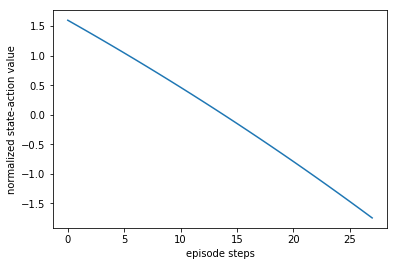

episode: 1   reward: 1704
episode: 2   reward: 1687
episode: 3   reward: 1670
episode: 4   reward: 1654
episode: 5   reward: 1637
episode: 6   reward: 1621
episode: 7   reward: 1605
episode: 8   reward: 1590
episode: 9   reward: 1574
episode: 10   reward: 1558
episode: 11   reward: 1543
episode: 12   reward: 1527
episode: 13   reward: 1512
episode: 14   reward: 1497
episode: 15   reward: 1483
episode: 16   reward: 1468
episode: 17   reward: 1453
episode: 18   reward: 1439
episode: 19   reward: 1425
episode: 20   reward: 1410
episode: 21   reward: 1396
episode: 22   reward: 1383
episode: 23   reward: 1369
episode: 24   reward: 1355
episode: 25   reward: 1342
episode: 26   reward: 1329
episode: 27   reward: 1315
episode: 28   reward: 1302
episode: 29   reward: 1290
episode: 30   reward: 1277
episode: 31   reward: 1264
episode: 32   reward: 1252
episode: 33   reward: 1239
episode: 34   reward: 1227
episode: 35   reward: 1215
episode: 36   reward: 1203
episode: 37   reward: 1191
episode: 3

episode: 308   reward: 87
episode: 309   reward: 86
episode: 310   reward: 85
episode: 311   reward: 85
episode: 312   reward: 84
episode: 313   reward: 83
episode: 314   reward: 82
episode: 315   reward: 82
episode: 316   reward: 81
episode: 317   reward: 80
episode: 318   reward: 79
episode: 319   reward: 79
episode: 320   reward: 78
episode: 321   reward: 77
episode: 322   reward: 77
episode: 323   reward: 76
episode: 324   reward: 75
episode: 325   reward: 75
episode: 326   reward: 74
episode: 327   reward: 73
episode: 328   reward: 73
episode: 329   reward: 72
episode: 330   reward: 71
episode: 331   reward: 71
episode: 332   reward: 70
episode: 333   reward: 70
episode: 334   reward: 69
episode: 335   reward: 68
episode: 336   reward: 68
episode: 337   reward: 67
episode: 338   reward: 67
episode: 339   reward: 66
episode: 340   reward: 65
episode: 341   reward: 65
episode: 342   reward: 64
episode: 343   reward: 64
episode: 344   reward: 63
episode: 345   reward: 63
episode: 346

episode: 639   reward: 12
episode: 640   reward: 12
episode: 641   reward: 12
episode: 642   reward: 12
episode: 643   reward: 12
episode: 644   reward: 11
episode: 645   reward: 11
episode: 646   reward: 11
episode: 647   reward: 11
episode: 648   reward: 11
episode: 649   reward: 11
episode: 650   reward: 11
episode: 651   reward: 11
episode: 652   reward: 11
episode: 653   reward: 11
episode: 654   reward: 11
episode: 655   reward: 11
episode: 656   reward: 11
episode: 657   reward: 11
episode: 658   reward: 11
episode: 659   reward: 11
episode: 660   reward: 11
episode: 661   reward: 11
episode: 662   reward: 11
episode: 663   reward: 11
episode: 664   reward: 11
episode: 665   reward: 11
episode: 666   reward: 11
episode: 667   reward: 11
episode: 668   reward: 11
episode: 669   reward: 11
episode: 670   reward: 11
episode: 671   reward: 11
episode: 672   reward: 11
episode: 673   reward: 11
episode: 674   reward: 11
episode: 675   reward: 11
episode: 676   reward: 11
episode: 677

episode: 962   reward: 10
episode: 963   reward: 10
episode: 964   reward: 10
episode: 965   reward: 10
episode: 966   reward: 10
episode: 967   reward: 10
episode: 968   reward: 10
episode: 969   reward: 10
episode: 970   reward: 10
episode: 971   reward: 10
episode: 972   reward: 10
episode: 973   reward: 10
episode: 974   reward: 10
episode: 975   reward: 10
episode: 976   reward: 10
episode: 977   reward: 10
episode: 978   reward: 10
episode: 979   reward: 10
episode: 980   reward: 10
episode: 981   reward: 10
episode: 982   reward: 10
episode: 983   reward: 10
episode: 984   reward: 10
episode: 985   reward: 10
episode: 986   reward: 10
episode: 987   reward: 10
episode: 988   reward: 10
episode: 989   reward: 10
episode: 990   reward: 10
episode: 991   reward: 10
episode: 992   reward: 10
episode: 993   reward: 10
episode: 994   reward: 10
episode: 995   reward: 10
episode: 996   reward: 10
episode: 997   reward: 11
episode: 998   reward: 10
episode: 999   reward: 10
episode: 100

episode: 1271   reward: 40
episode: 1272   reward: 41
episode: 1273   reward: 43
episode: 1274   reward: 44
episode: 1275   reward: 45
episode: 1276   reward: 46
episode: 1277   reward: 47
episode: 1278   reward: 49
episode: 1279   reward: 49
episode: 1280   reward: 50
episode: 1281   reward: 51
episode: 1282   reward: 52
episode: 1283   reward: 52
episode: 1284   reward: 53
episode: 1285   reward: 54
episode: 1286   reward: 54
episode: 1287   reward: 55
episode: 1288   reward: 56
episode: 1289   reward: 56
episode: 1290   reward: 56
episode: 1291   reward: 57
episode: 1292   reward: 57
episode: 1293   reward: 58
episode: 1294   reward: 59
episode: 1295   reward: 59
episode: 1296   reward: 60
episode: 1297   reward: 60
episode: 1298   reward: 62
episode: 1299   reward: 62
episode: 1300   reward: 63
episode: 1301   reward: 64
episode: 1302   reward: 65
episode: 1303   reward: 66
episode: 1304   reward: 67
episode: 1305   reward: 68
episode: 1306   reward: 69
episode: 1307   reward: 70
e

episode: 1568   reward: 148
episode: 1569   reward: 148
episode: 1570   reward: 149
episode: 1571   reward: 149
episode: 1572   reward: 150
episode: 1573   reward: 150
episode: 1574   reward: 151
episode: 1575   reward: 151
episode: 1576   reward: 152
episode: 1577   reward: 152
episode: 1578   reward: 153
episode: 1579   reward: 153
episode: 1580   reward: 154
episode: 1581   reward: 154
episode: 1582   reward: 155
episode: 1583   reward: 155
episode: 1584   reward: 155
episode: 1585   reward: 156
episode: 1586   reward: 156
episode: 1587   reward: 156
episode: 1588   reward: 157
episode: 1589   reward: 157
episode: 1590   reward: 157
episode: 1591   reward: 157
episode: 1592   reward: 157
episode: 1593   reward: 158
episode: 1594   reward: 158
episode: 1595   reward: 158
episode: 1596   reward: 158
episode: 1597   reward: 157
episode: 1598   reward: 157
episode: 1599   reward: 157
episode: 1600   reward: 156
episode: 1601   reward: 156
episode: 1602   reward: 155
episode: 1603   rewa

episode: 1861   reward: 179
episode: 1862   reward: 179
episode: 1863   reward: 179
episode: 1864   reward: 180
episode: 1865   reward: 180
episode: 1866   reward: 180
episode: 1867   reward: 180
episode: 1868   reward: 180
episode: 1869   reward: 181
episode: 1870   reward: 181
episode: 1871   reward: 181
episode: 1872   reward: 181
episode: 1873   reward: 181
episode: 1874   reward: 181
episode: 1875   reward: 182
episode: 1876   reward: 182
episode: 1877   reward: 182
episode: 1878   reward: 182
episode: 1879   reward: 182


KeyboardInterrupt: 

In [30]:
import gym
import matplotlib.pyplot as plt

DISPLAY_REWARD_THRESHOLD = 400  # renders environment if total episode reward is greater then this threshold
RENDER = False  # rendering wastes time

env = gym.make('CartPole-v0')
#env.seed(1)     # reproducible, general Policy gradient has high variance
#env = env.unwrapped

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

RL = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.99,
    # output_graph=True,
)

for i_episode in range(3000):

    observation = env.reset()

    while True:
        if RENDER: env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        RL.store_transition(observation, action, reward)

        if done:
            ep_rs_sum = sum(RL.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            #if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = RL.learn()

            if i_episode == 0:
                plt.plot(vt)    # plot the episode vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break

        observation = observation_

# Network Data Preprocessing

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time as t
from IPython.display import clear_output
from itertools import islice
import collections
import copy

In [20]:
df = pd.read_csv('log20170630.csv')
df.head()

/Users/jeffreyping/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ip        date      time  zone        cik  \
0  101.81.133.jja  2017-06-30  00:00:00   0.0  1608552.0   
1   107.23.85.jfd  2017-06-30  00:00:00   0.0  1027281.0   
2   107.23.85.jfd  2017-06-30  00:00:00   0.0  1136894.0   
3   107.23.85.jfd  2017-06-30  00:00:00   0.0  1136894.0   
4   107.23.85.jfd  2017-06-30  00:00:00   0.0  1136894.0   

              accession   extention   code     size  idx  norefer  noagent  \
0  0001047469-17-004337  -index.htm  200.0  80251.0  1.0      0.0      0.0   
1  0000898430-02-001167  -index.htm  200.0   2825.0  1.0      0.0      0.0   
2  0000905148-07-003827  -index.htm  200.0   3021.0  1.0      0.0      0.0   
3  0000905148-07-005350  -index.htm  200.0   2952.0  1.0      0.0      0.0   
4  0000905148-07-003547  -index.htm  200.0   3061.0  1.0      0.0      0.0   

   find  crawler browser  
0   9.0      0.0     NaN  
1  10.0      0.0     NaN  
2  10.0      0.0     NaN  
3  10.0      0.0     NaN  
4  10.0      0.0     NaN

In [21]:
df2 = pd.DataFrame({'ip':df['ip'], 'time':df['time'], 'size': df['size'], 'one':[1]*len(df)})
df2.head()

ip  one     size      time
0  101.81.133.jja    1  80251.0  00:00:00
1   107.23.85.jfd    1   2825.0  00:00:00
2   107.23.85.jfd    1   3021.0  00:00:00
3   107.23.85.jfd    1   2952.0  00:00:00
4   107.23.85.jfd    1   3061.0  00:00:00

In [22]:
dfit = pd.DataFrame({'ip':df['ip'], 'time':df['time'], 'one':[1]*len(df)}).drop_duplicates()
pickIp = list(dfit.groupby(by='ip').sum().sort_values(by=['one']).tail(18).index)

In [23]:
#pickIp = list(set(df2[df2['time'] == '23:22:10']['ip'].values))
df3 = df2[df2['ip'].isin(pickIp)]
df4 = df3.copy()
df4.index = range(len(df4))

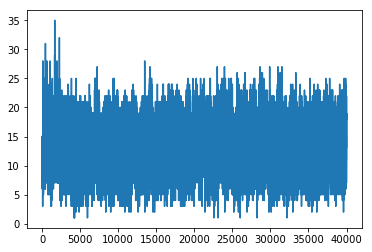

In [24]:
normalUsers = pickIp[:6]
dfnu = df4[df4['ip'].isin(normalUsers)]
plt.plot(dfnu.groupby(by='time').sum()['one'].values[:40000])
plt.show()

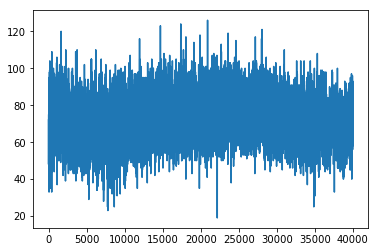

In [25]:
plt.plot(df4.groupby(by='time').sum()['one'].values[:40000])
plt.show()

In [26]:
ipToIndex = {k: v for v, k in enumerate(pickIp)}
df5 = df4.copy()
df5['ip'] = df5['ip'].apply(lambda x: ipToIndex[x])
df5.head()

ip  one     size      time
0   4    1  80251.0  00:00:00
1  15    1   1470.0  00:00:00
2  15    1   1696.0  00:00:00
3  15    1   2878.0  00:00:00
4  15    1   3539.0  00:00:00

# Data 2

In [37]:
dff = pd.read_csv('log20170629.csv')
dff.head()

/Users/jeffreyping/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ip        date      time  zone        cik  \
0  101.81.133.jja  2017-06-29  00:00:00   0.0  1515671.0   
1  101.81.133.jja  2017-06-29  00:00:00   0.0  1105685.0   
2   101.81.77.ach  2017-06-29  00:00:00   0.0   104894.0   
3   107.23.85.jfd  2017-06-29  00:00:00   0.0  1305479.0   
4   107.23.85.jfd  2017-06-29  00:00:00   0.0  1336279.0   

              accession   extention   code    size  idx  norefer  noagent  \
0  0000940400-17-000412  -index.htm  200.0  6832.0  1.0      0.0      0.0   
1  0001209191-17-042148  -index.htm  200.0  9902.0  1.0      0.0      0.0   
2  0001193125-10-215678  -index.htm  200.0  7857.0  1.0      0.0      0.0   
3  0000905148-06-007070  -index.htm  200.0  2944.0  1.0      0.0      0.0   
4  0001193125-07-254842  -index.htm  200.0  2845.0  1.0      0.0      0.0   

   find  crawler browser  
0   9.0      0.0     NaN  
1   9.0      0.0     NaN  
2  10.0      0.0     NaN  
3  10.0      0.0     NaN  
4  10.0      0.0     NaN

In [38]:
dff2 = pd.DataFrame({'ip':dff['ip'], 'time':dff['time'], 'size': dff['size'], 'one':[1]*len(dff)})
dff2.head()

ip  one    size      time
0  101.81.133.jja    1  6832.0  00:00:00
1  101.81.133.jja    1  9902.0  00:00:00
2   101.81.77.ach    1  7857.0  00:00:00
3   107.23.85.jfd    1  2944.0  00:00:00
4   107.23.85.jfd    1  2845.0  00:00:00

In [185]:
dffit = pd.DataFrame({'ip':dff['ip'], 'time':dff['time'], 'one':[1]*len(dff)}).drop_duplicates()
pi2 = list(dffit.groupby(by='ip').sum().sort_values(by=['one']).tail(18).index)

In [250]:
pickIp2 = pickIp[6:] + pickIp[:6] #pi2[2:5] + pi2[9:] + pi2[:2] + pi2[5:9]

In [248]:
dff3 = dff2[dff2['ip'].isin(pickIp)]
dff4 = dff3.copy()
dff4.index = range(len(dff4))

In [200]:
a = [0,1,2,3,4,5,6,7,8,9,10, 11,12,13,14]
b = a[3:11] + a[14:] + a[:3] + a[11:14]
print(b, b[-6:], len(pickIp2))

[3, 4, 5, 6, 7, 8, 9, 10, 14, 0, 1, 2, 11, 12, 13] [0, 1, 2, 11, 12, 13] 18


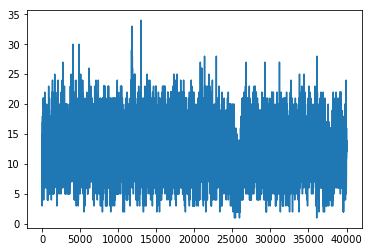

In [251]:
normalUsers2 = pickIp2[-6:]#[5:9] + pickIp2[:2]
dffnu = dff4[dff4['ip'].isin(normalUsers)]
plt.plot(dffnu.groupby(by='time').sum()['one'].values[:40000])
plt.show()

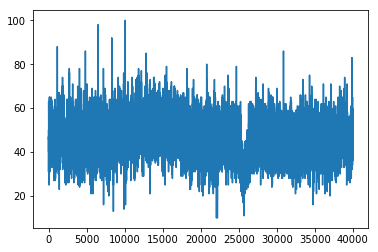

In [252]:
plt.plot(dff4.groupby(by='time').sum()['one'].values[:40000])
plt.show()

In [289]:
ipToIndex2 = {k: v for v, k in enumerate(pickIp2)}
dff5 = dff4.copy()
dff5['ip'] = dff5['ip'].apply(lambda x: ipToIndex2[x])
dff5.head()

ip  one     size      time
0  16    1   6832.0  00:00:00
1  16    1   9902.0  00:00:00
2   5    1  30925.0  00:00:00
3   5    1   4904.0  00:00:00
4   5    1  12945.0  00:00:00

# All data

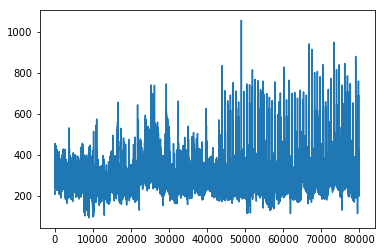

In [15]:
plt.plot(df2.groupby(by='time').sum()['one'].values[:80000])
plt.show()

In [16]:
min(df2.groupby(by='time').sum()['one'].values[:80000])

93

In [108]:
pickIp2 = dfit.groupby(by='ip').sum().sort_values(by=['one']).tail(24).index[:-8]

In [112]:
df6 = df2[df2['ip'].isin(pickIp2)]

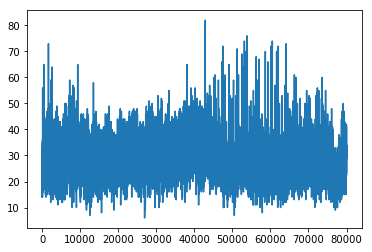

In [110]:
plt.plot(df6.groupby(by='time').sum()['one'].values[:80000])
plt.show()

In [113]:
max(df6.groupby(by='time').sum()['one'].values[:80000])

82

In [127]:
ipToIndex = {k: v for v, k in enumerate(list(set(df2['ip'])))}
df7 = df2.copy()
df7['ip'] = df7['ip'].apply(lambda x: ipToIndex[x])
df7.head()

ip  one     size      time
0   7875    1  80251.0  00:00:00
1  56924    1   2825.0  00:00:00
2  56924    1   3021.0  00:00:00
3  56924    1   2952.0  00:00:00
4  56924    1   3061.0  00:00:00

In [98]:
len(list(set(df2['ip'])))

78181

# Plot Function

In [27]:
results = []

def toColor(num):
    colors = ['green', 'red', 'grey', 'blue']
    return colors[num]

def plotAction(index):
    plt.figure(figsize=(20,10))
    plt.scatter(range(len(results[index][1])), results[index][1], color = list(map(toColor, results[index][2])))
    plt.show()
    
def plotReward(index):
    plt.figure(figsize=(20,10))
    plt.scatter(range(len(results[index][0])), results[index][0], color = list(map(toColor, results[index][2])))
    plt.show()

def plotRewardLine(index):
    rewardLine = []
    count = 0
    aggre = 0
    for i in range(len(results[index][1])):
        if results[index][2]:
            count += 1
            aggre += results[index][0][i]
            if count == 100:
                rewardLine.append(aggre / 100)
                aggre = 0
                count = 0
    plt.figure(figsize=(20,10))
    plt.plot(rewardLine)
    plt.show()

# DQN for DDoS without/with fast iterator

In [8]:
def diffSec(str1, str2):
    return (dt.datetime.strptime(str1, "%H:%M:%S") - dt.datetime.strptime(str2, "%H:%M:%S")).total_seconds()

In [13]:
def getFlatState():
    tempState = list(copy.deepcopy(state).values())
    flatState = [item for sublist in tempState for item in sublist]
    return flatState

In [44]:
def computeState(currentTime):
    for key in fv:
        npq = fv[key][0]
        mtq = fv[key][1]
        psl = fv[key][2]

        if len(npq) == 10:
            state[key][0] = sum(list(npq))

        if len(mtq) == 11:
            tt = 0
            for i in range(len(mtq) - 1):
                tt += diffSec(mtq[i + 1], mtq[i])
            state[key][1] = tt/10

        if len(mtq) != 0:
            state[key][2] = diffSec(currentTime, mtq[len(mtq) - 1])

        state[key][3] = psl[0]
        state[key][4] = psl[1]
        state[key][5] = psl[2]

In [138]:
def envStep(stateID, action):
    
    blockList = []
    for i in range(len(action)):
        if action[i] == 0:
            blockList.append(pickIp[i])
            
    startTime = df4.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    total = 0
    
    for index, row in islice(df4.iterrows(), stateID, None):
        
        if int(diffSec(row['time'],startTime)) == windowSize:
            
            computeState(row['time'])
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    reward = 0
                else:
                    reward = normalNum/total
            return index, reward
        
        if row['ip'] in blockList:
            continue
        elif row['ip'] in normalUsers:
            normalNum += 1
        
        total += 1
        
        npq = fv[row['ip']][0]
        mtq = fv[row['ip']][1]
        psl = fv[row['ip']][2]

        #Update number of packet queue
        if len(npq) == 0: 
            npq.append(1)
        elif mtq[len(mtq) - 1] != row['time']:
            for i in range(int(diffSec(row['time'], mtq[len(mtq) - 1])) - 1):
                npq.append(0)
            npq.append(1)
        else:
            npq[len(npq) - 1] += 1

        #Update mean time interval queue
        fv[row['ip']][1].append(row['time'])

        #Update packet size list
        if psl[0] == -1:
            for i in range(3):
                psl[i] = row['size']
            psl[3] = 1
        else:
            psl[2] = (psl[2]*psl[3] + row['size'])/(psl[3] + 1)
            psl[3] += 1

            if row['size'] > psl[0]:
                psl[0] = row['size']
            if row['size'] < psl[1]:
                psl[1] = row['size']

In [253]:
def envStepFast(stateID, action):
    
    blockList = []
    for i in range(len(action)):
        if action[i] == 0:
            blockList.append(pickIp[i])
            
    startTime = df4.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    total = 0
    
    for row in islice(df4.itertuples(), stateID, None):
        
        if int(diffSec(getattr(row, 'time'),startTime)) == windowSize:
            
            computeState(getattr(row, 'time'))
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    reward = 0
                else:
                    reward = normalNum/total
            return getattr(row, 'Index'), reward
        
        if getattr(row, 'ip') in blockList:
            continue
        elif getattr(row, 'ip') in normalUsers:
            normalNum += 1
        
        total += 1
        
        npq = fv[getattr(row, 'ip')][0]
        mtq = fv[getattr(row, 'ip')][1]
        psl = fv[getattr(row, 'ip')][2]

        #Update number of packet queue
        if len(npq) == 0: 
            npq.append(1)
        elif mtq[len(mtq) - 1] != getattr(row, 'time'):
            for i in range(int(diffSec(getattr(row, 'time'), mtq[len(mtq) - 1])) - 1):
                npq.append(0)
            npq.append(1)
        else:
            npq[len(npq) - 1] += 1

        #Update mean time interval queue
        fv[getattr(row, 'ip')][1].append(getattr(row, 'time'))

        #Update packet size list
        if psl[0] == -1:
            for i in range(3):
                psl[i] = getattr(row, 'size')
            psl[3] = 1
        else:
            psl[2] = (psl[2]*psl[3] + getattr(row, 'size'))/(psl[3] + 1)
            psl[3] += 1

            if getattr(row, 'size') > psl[0]:
                psl[0] = getattr(row, 'size')
            if getattr(row, 'size') < psl[1]:
                psl[1] = getattr(row, 'size')

In [574]:
#initialize parameters
windowSize = 1
maxLoad = 30
actionNum = 3
actions = {}
for i in range(actionNum - 1):
    actions[i] = np.random.choice([0, 1], size=(18,), p=[2./3, 1./3])
actions[actionNum - 1] = [1]*6 + [0]*12

#initialize feature vector & state
fv = {}
for ip in pickIp:
    #number of packets in past 10 sec, mean time interval of past 10 packets, size 
    fv[ip] = [collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4]

state = {}
for ip in pickIp:
    #number of packets, mean time interval, last visit time, max/min/mean size
    state[ip] = [-1]*6

In [575]:
stateID, r = envStep(0, [1]*18)

In [576]:
# Environment parameters
n_actions = len(actions)
n_states = len(pickIp)*6

# Hyper parameters
n_hidden = 1000
batch_size = 20
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 50  # target network 更新間隔
memory_capacity = 150
steps = 5000

# Visualization
rewardList = [-1]*20
actionList = []
exploreList = []

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = getFlatState()
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    next_stateID, reward = envStepFast(stateID, actions[action])
    ns = getFlatState()
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 50 == 0:
        print(action)

1
1
0
0
0
1
2
1
1
2
0
2
0
0
0
0
0
0
1
2
2
1
2
0
2
1
2
0
2
1
2
1
1
2
0
2
1
2
0
2
0
1
1
2
0
1
2
0
2
1
0
2
2
0
2
0
1
2
2
2
0
1
1
1
2
2
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [679]:
def toColor(num):
    colors = ['green', 'red', 'grey', 'blue']
    return colors[num]

In [577]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

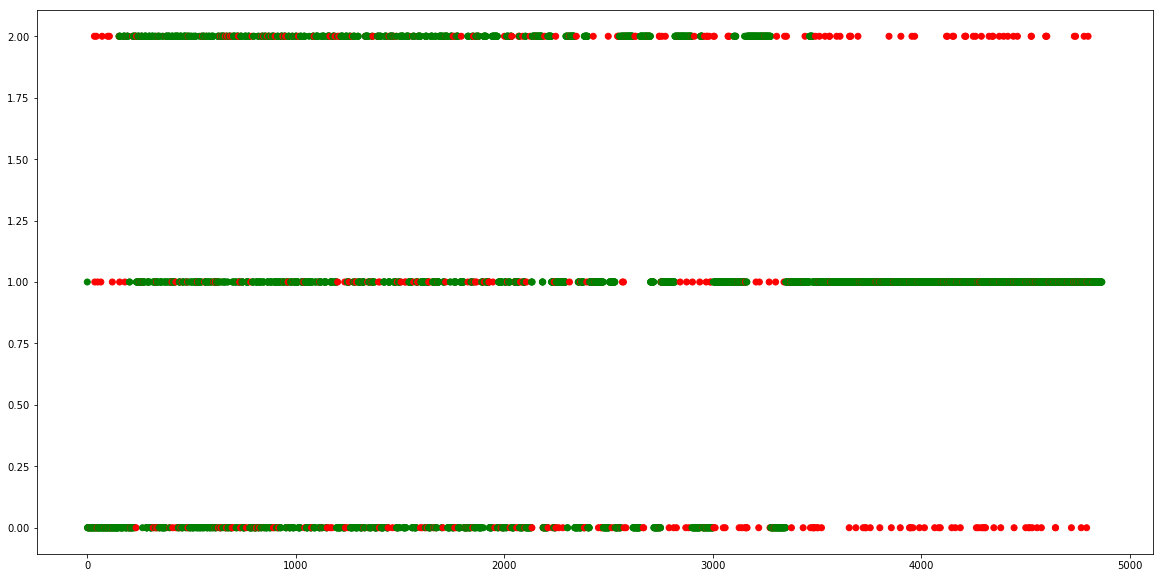

In [578]:
plotAction(len(results) - 1)

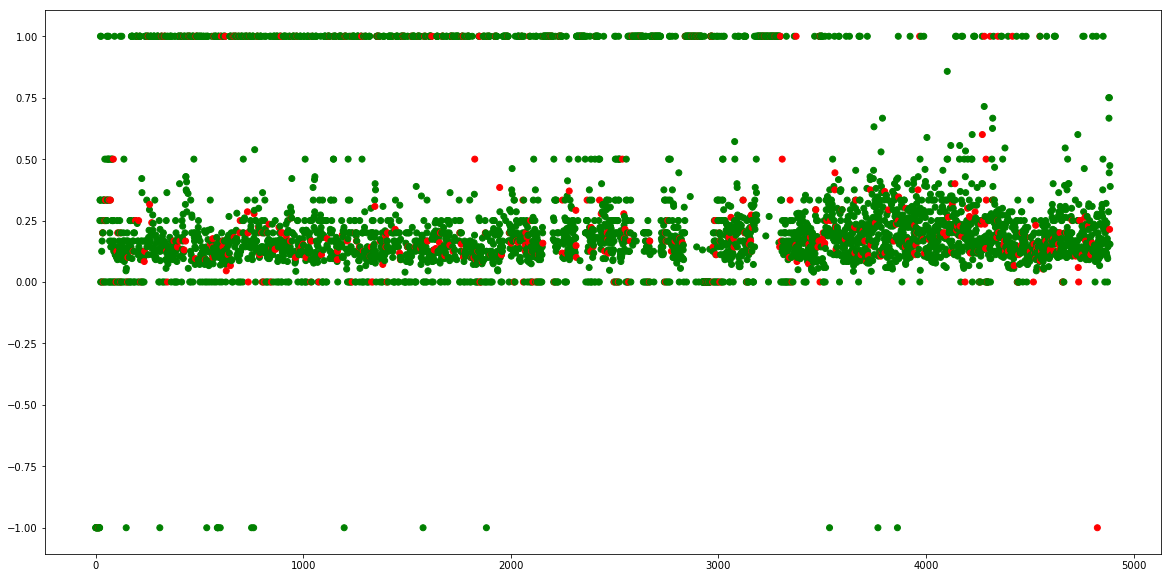

In [579]:
plotReward(len(results) - 1)

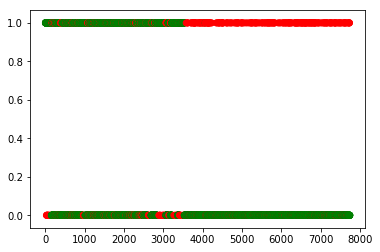

In [260]:
plt.scatter(range(len(results[len(results) - 1][1])), results[len(results) - 1][1], color = list(map(toColor, results[len(results) - 1][2])))
plt.show()

# DQN for DDoS with fast iterator and replacing dictionary by list

In [45]:
def diffSec(str1, str2):
    return (dt.datetime.strptime(str1, "%H:%M:%S") - dt.datetime.strptime(str2, "%H:%M:%S")).total_seconds()

In [46]:
def getFlatStateL():
    flatState = [item for sublist in stateL for item in sublist]
    return flatState

In [47]:
def computeStateL(currentTime):
    for key in range(len(fvL)):
        npq = fvL[key][0]
        mtq = fvL[key][1]
        psl = fvL[key][2]

        if len(npq) == 10:
            stateL[key][0] = sum(list(npq))

        if len(mtq) == 11:
            tt = 0
            for i in range(len(mtq) - 1):
                tt += diffSec(mtq[i + 1], mtq[i])
            stateL[key][1] = tt/10

        if len(mtq) != 0:
            stateL[key][2] = diffSec(currentTime, mtq[len(mtq) - 1])

        stateL[key][3] = psl[0]
        stateL[key][4] = psl[1]
        stateL[key][5] = psl[2]

In [87]:
def envStepFastL(stateID, action):
    
    blockList = []
    for i in range(len(action)):
        if action[i] == 0:
            blockList.append(i)
            
    startTime = df5.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    total = 0
    
    for row in islice(df5.itertuples(), stateID, None):
        
        if int(diffSec(getattr(row, 'time'),startTime)) == windowSize:
            
            computeStateL(getattr(row, 'time'))
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    print('no packet!')
                    reward = 0
                else:
                    reward = normalNum/total
            return getattr(row, 'Index'), reward
        
        if getattr(row, 'ip') in blockList:
            continue
        elif getattr(row, 'ip') in [ipToIndex[ip] for ip in normalUsers]:
            normalNum += 1
        
        total += 1
        
        npq = fvL[getattr(row, 'ip')][0]
        mtq = fvL[getattr(row, 'ip')][1]
        psl = fvL[getattr(row, 'ip')][2]

        #Update number of packet queue
        if len(npq) == 0: 
            npq.append(1)
        elif mtq[len(mtq) - 1] != getattr(row, 'time'):
            for i in range(int(diffSec(getattr(row, 'time'), mtq[len(mtq) - 1])) - 1):
                npq.append(0)
            npq.append(1)
        else:
            npq[len(npq) - 1] += 1

        #Update mean time interval queue
        fvL[getattr(row, 'ip')][1].append(getattr(row, 'time'))

        #Update packet size list
        if psl[0] == -1:
            for i in range(3):
                psl[i] = getattr(row, 'size')
            psl[3] = 1
        else:
            psl[2] = (psl[2]*psl[3] + getattr(row, 'size'))/(psl[3] + 1)
            psl[3] += 1

            if getattr(row, 'size') > psl[0]:
                psl[0] = getattr(row, 'size')
            if getattr(row, 'size') < psl[1]:
                psl[1] = getattr(row, 'size')

In [157]:
#initialize parameters
windowSize = 1
maxLoad = 30
actionNum = 10
actions = {}
for i in range(actionNum - 1):
    actions[i] = np.random.choice([0, 1], size=(18,), p=[2./3, 1./3])
actions[actionNum - 1] = [1]*6 + [0]*12

#initialize feature vector & state

#number of packets in past 10 sec, mean time interval of past 10 packets, size 
fvL = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4] for i in range(len(pickIp))]
stateL = [[-1]*6 for i in range(len(pickIp))]

In [158]:
stateID, r = envStepFastL(0, [1]*18)

In [159]:
# Environment parameters
n_actions = len(actions)
n_states = len(pickIp)*6

# Hyper parameters
n_hidden = 1000
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100  # target network 更新間隔
memory_capacity = 2000
steps = 8000

# Visualization
rewardList = []
actionList = []
exploreList = []

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = getFlatStateL()
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    next_stateID, reward = envStepFastL(stateID, actions[action])
    ns = getFlatStateL()
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 50 == 0:
        print(action, reward)

6 0.35294117647058826


KeyboardInterrupt: 

In [802]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

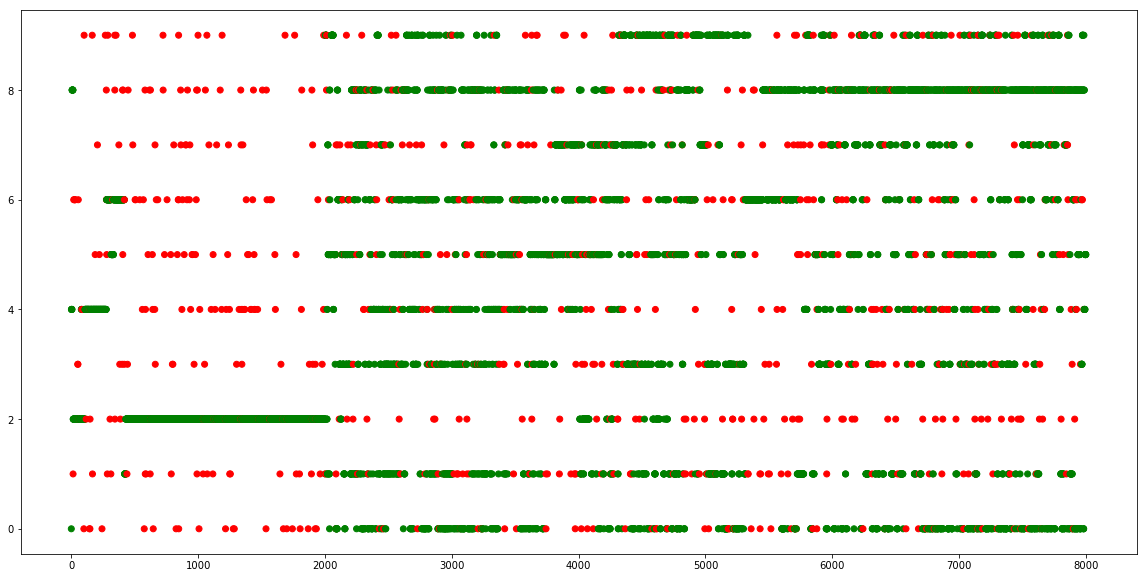

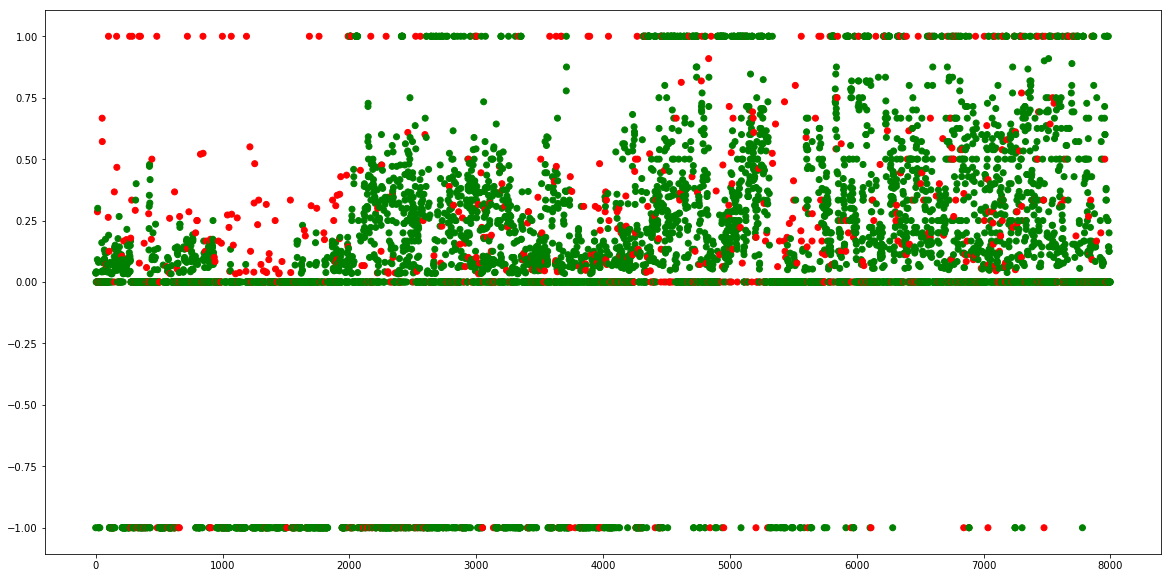

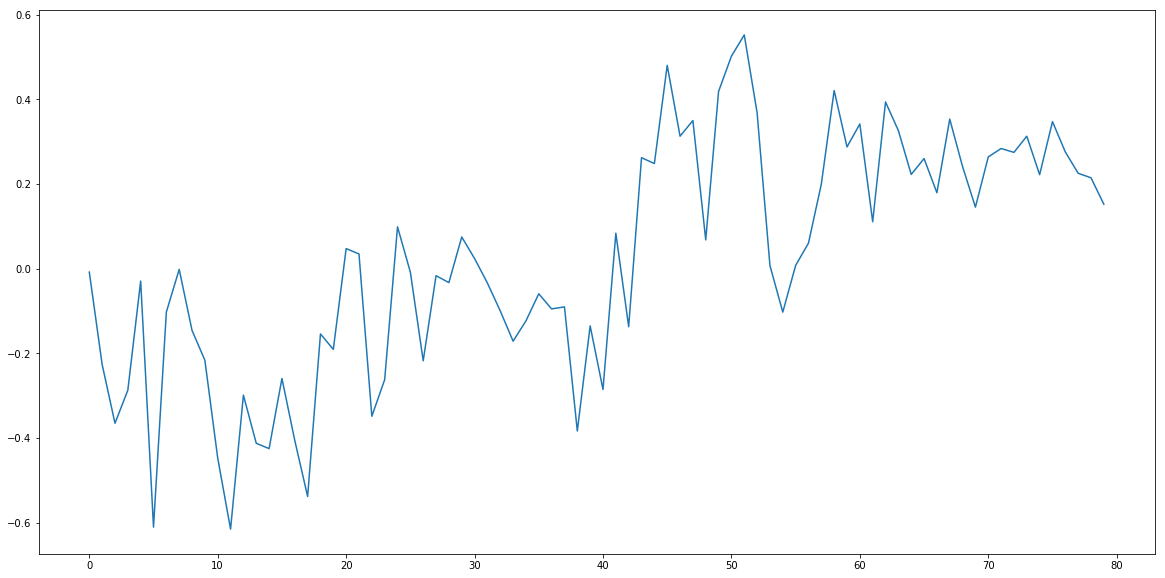

In [804]:
# 38 plot
plotAction(38)
plotReward(38)
plotRewardLine(38)

In [365]:
def plotAction(index):
    plt.figure(figsize=(20,10))
    plt.scatter(range(len(results[index][1])), results[index][1], color = list(map(toColor, results[index][2])))
    plt.show()
    
def plotReward(index):
    plt.figure(figsize=(20,10))
    plt.scatter(range(len(results[index][0])), results[index][0], color = list(map(toColor, results[index][2])))
    plt.show()

# DQN for DDoS with one step action

In [371]:
df5.head()

ip  one     size      time
0  11    1  80251.0  00:00:00
1  10    1   2825.0  00:00:00
2  10    1   3021.0  00:00:00
3  10    1   2952.0  00:00:00
4  10    1   3061.0  00:00:00

In [437]:
def getFlatStateLO():
    flatState = [item for sublist in stateLO for item in sublist]
    return flatState

In [438]:
def computeStateLO(currentTime):
    for key in range(len(fvLO)):
        npq = fvLO[key][0]
        mtq = fvLO[key][1]
        psl = fvLO[key][2]

        if len(npq) == 10:
            stateLO[key][0] = sum(list(npq))

        if len(mtq) == 11:
            tt = 0
            for i in range(len(mtq) - 1):
                tt += diffSec(mtq[i + 1], mtq[i])
            stateLO[key][1] = tt/10

        if len(mtq) != 0:
            stateLO[key][2] = diffSec(currentTime, mtq[len(mtq) - 1])

        stateLO[key][3] = psl[0]
        stateLO[key][4] = psl[1]
        stateLO[key][5] = psl[2]
        
        stateLO[key][6] = fvLO[key][3]

In [520]:
def envStepFastLO(stateID, action):
    
    if action != len(pickIp):
        fvLO[action][3] = (fvLO[action][3] + 1) % 2
    
    blockList = []
    for i in range(len(fvLO)):
        if fvLO[i][3] == 0:
            blockList.append(i)
            
    startTime = df5.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    total = 0
    
    for row in islice(df5.itertuples(), stateID, None):
        
        nowIp = int(getattr(row, 'ip'))
        
        if int(diffSec(getattr(row, 'time'),startTime)) == windowSize:
            
            computeStateLO(getattr(row, 'time'))
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    print('no packet!')
                    reward = 0
                else:
                    reward = normalNum/total
            return getattr(row, 'Index'), reward
        
        if nowIp in blockList:
            continue
        elif nowIp in [ipToIndex[ip] for ip in normalUsers]:
            normalNum += 1
        
        total += 1
        
        npq = fvLO[nowIp][0]
        mtq = fvLO[nowIp][1]
        psl = fvLO[nowIp][2]
        
        #Update number of packet queue
        if len(npq) == 0: 
            npq.append(1)
        elif mtq[len(mtq) - 1] != getattr(row, 'time'):
            for i in range(int(diffSec(getattr(row, 'time'), mtq[len(mtq) - 1])) - 1):
                npq.append(0)
            npq.append(1)
        else:
            npq[len(npq) - 1] += 1
                
        #Update mean time interval queue
        fvLO[nowIp][1].append(getattr(row, 'time'))

        #Update packet size list
        if psl[0] == -1:
            for i in range(3):
                psl[i] = getattr(row, 'size')
            psl[3] = 1
        else:
            psl[2] = (psl[2]*psl[3] + getattr(row, 'size'))/(psl[3] + 1)
            psl[3] += 1

            if getattr(row, 'size') > psl[0]:
                psl[0] = getattr(row, 'size')
            if getattr(row, 'size') < psl[1]:
                psl[1] = getattr(row, 'size')

In [538]:
#initialize parameters
windowSize = 1
maxLoad = 30

#initialize feature vector & state

#number of packets in past 10 sec, mean time interval of past 10 packets, size 
fvLO = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4, 1] for i in range(len(pickIp))]
stateLO = [[-1]*6 + [1] for i in range(len(pickIp))]

In [539]:
stateID, r = envStepFastLO(0, len(pickIp))

In [540]:
# Environment parameters
n_actions = len(pickIp) + 1
n_states = len(pickIp)*7

# Hyper parameters
n_hidden = 1000
batch_size = 20
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 1               # reward discount factor
target_replace_iter = 50  # target network 更新間隔
memory_capacity = 200
steps = 5000

# Visualization
rewardList = []
actionList = []
exploreList = []

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = getFlatStateLO()
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    next_stateID, reward = envStepFastLO(stateID, action)
    ns = getFlatStateLO()
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 50 == 0:
        print(action, reward)

14 -1
8 -1
10 0.391304347826087
3 0.2857142857142857
10 0.1
5 0.47368421052631576
3 0.23529411764705882
5 0.14285714285714285
9 0.375
6 0.4
15 0.125
1 0.0
18 0.125
11 0.037037037037037035
8 0.4166666666666667
4 0.25925925925925924
10 0.2
no packet!
7 0.125
no packet!
15 0.14285714285714285
6 0.16666666666666666
10 -1
9 0.13043478260869565
17 0.2
9 -1
13 0.6666666666666666
0 0.1111111111111111
5 -1
1 0.2222222222222222
17 0.2857142857142857
11 0.15384615384615385
17 0.6875
13 -1
4 -1
6 -1
7 0.125
0 -1
1 0.25
12 0.16666666666666666
7 0.3333333333333333
14 0.16666666666666666
7 -1
11 0.04
4 -1
5 -1
12 -1
10 0.46153846153846156
9 0.0
13 0.0
7 0.25
16 0.13043478260869565
16 0.13793103448275862
16 -1
17 -1
2 0.1
16 -1
6 0.1111111111111111
7 0.10526315789473684
12 0.0
0 -1
2 0.3333333333333333
7 0.23076923076923078
13 -1
2 -1
12 -1
1 0.3157894736842105
6 0.4166666666666667
6 0.39285714285714285
0 -1
6 0.0
11 -1
8 0.5
17 0.05263157894736842
16 0.2222222222222222
7 -1
10 -1
2 -1
1 0.08695652173

In [541]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

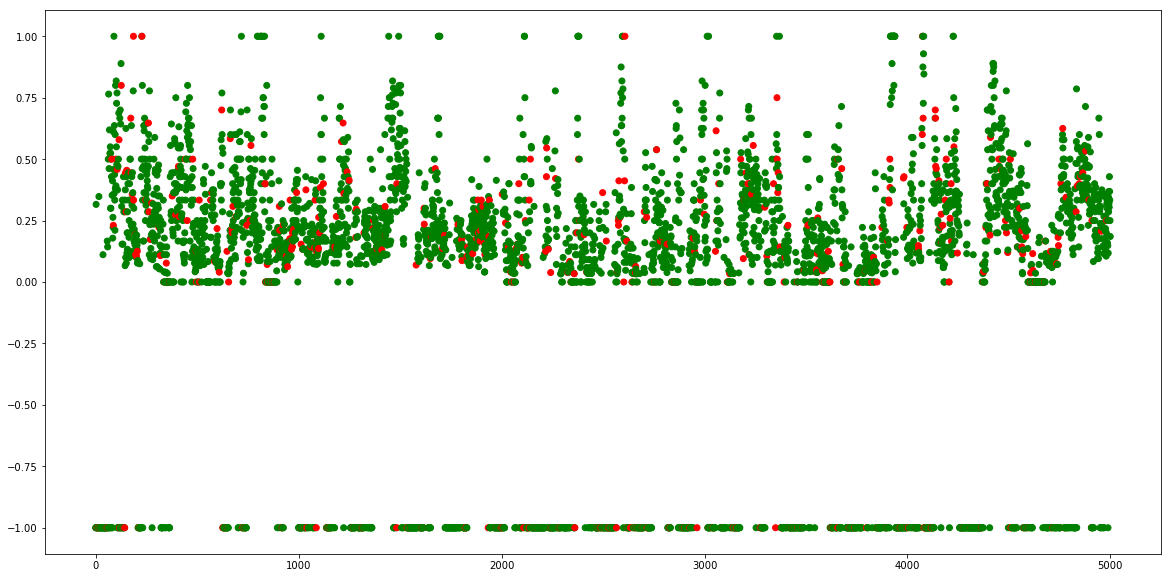

In [544]:
plotReward(len(results) - 1)

# Q Learning for DDoS

In [585]:
def stateToIndex(Qstate):
    index = 0
    for i in range(len(Qstate)):
        index += (2**i)*Qstate[i]
    return index

In [593]:
class QL(object):
    def __init__(self, n_states, n_actions, lr, epsilon, gamma):
        
        self.QTable = [[0 for i in range(n_actions)] for j in range(n_states)]
        
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        
    def choose_action(self, Qstate, explore = True):
        state = stateToIndex(Qstate)
        
        # epsilon-greedy
        if np.random.uniform() < self.epsilon and explore: # 隨機
            action = np.random.randint(0, self.n_actions)
            return action, 1
        else: # 根據現有 policy 做最好的選擇
            action = np.argmax(self.QTable[state]) # 挑選最高分的 action
            return action, 0

    def learn(self, state, action, reward, n_state):
        
        self.QTable[state][action] += self.lr*(reward + self.gamma*max(self.QTable[n_state]) - self.QTable[state][action])


In [604]:
def envStepFastLQ(stateID, action):
    
    blockList = []
    for i in range(len(action)):
        if action[i] == 0:
            blockList.append(i)
            
    startTime = df5.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    total = 0
    
    for row in islice(df5.itertuples(), stateID, None):
        
        if int(diffSec(getattr(row, 'time'),startTime)) == windowSize:
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    print('no packet!')
                    reward = 0
                else:
                    reward = normalNum/total
            return getattr(row, 'Index'), reward
        
        if getattr(row, 'ip') in blockList:
            continue
        elif getattr(row, 'ip') in [ipToIndex[ip] for ip in normalUsers]:
            normalNum += 1
        
        total += 1

In [605]:
#initialize parameters
windowSize = 1
maxLoad = 30

#initialize state
Qstate = [1]*len(pickIp)

In [606]:
stateID, r = envStepFastL(0, Qstate)

In [607]:
# Environment parameters
n_actions = len(pickIp) + 1
n_states = 2**len(pickIp)

# Hyper parameters
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
steps = 5000

# Visualization
rewardList = []
actionList = []
exploreList = []

# 建立 DQN
ql = QL(n_states, n_actions, lr, epsilon, gamma)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = stateToIndex(Qstate)
    action, explore = ql.choose_action(Qstate)
    
    # 執行 action
    if action != len(pickIp):
        Qstate[action] = (Qstate[action] + 1) % 2
    
    next_stateID, reward = envStepFastLQ(stateID, Qstate)
    ns = stateToIndex(Qstate)
    
    # Update Q table
    ql.learn(s, action, reward, ns)

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 50 == 0:
        print(action, reward)

0 -1
0 0.375
3 0.038461538461538464
1 0.12
0 0.08695652173913043
0 0.2857142857142857
0 0.13333333333333333
0 0.13636363636363635
0 0.10526315789473684
10 0.09523809523809523
0 0.06666666666666667
1 0.034482758620689655
0 0.6190476190476191
0 0.25
0 0.3333333333333333
0 0.18518518518518517
0 0.13333333333333333
0 1.0
0 0.36363636363636365
0 0.25
0 0.0
9 0.0
0 0.0
0 0.06666666666666667
0 0.3333333333333333
0 0.5454545454545454
0 -1
7 -1


KeyboardInterrupt: 

In [608]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

In [609]:
qso.append(Qstate)
qso[len(qso) - 1]

[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]

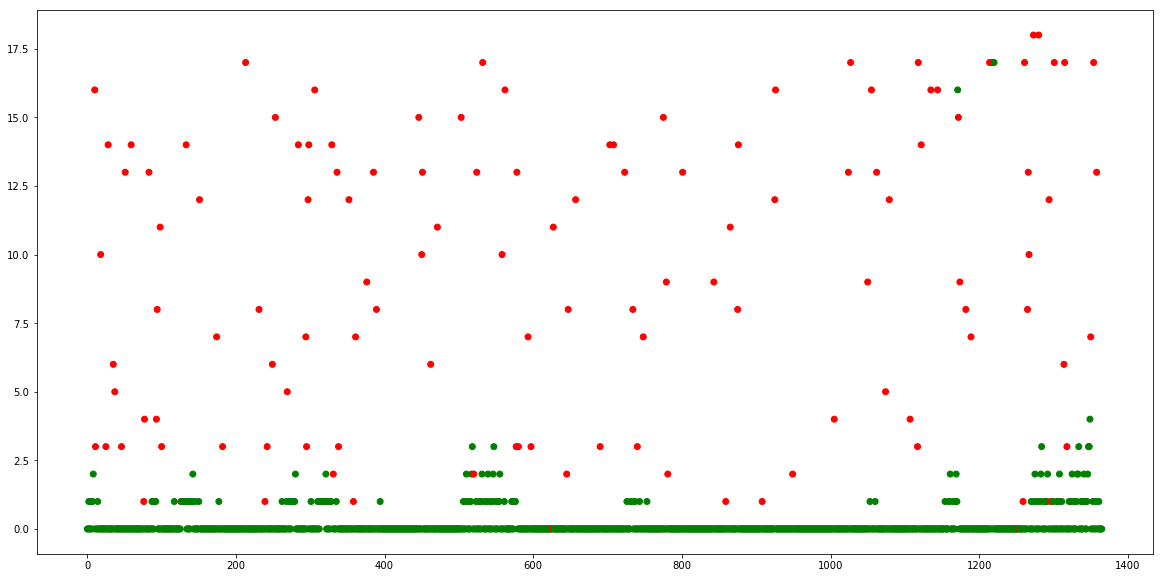

In [610]:
plotAction(len(results) - 1)

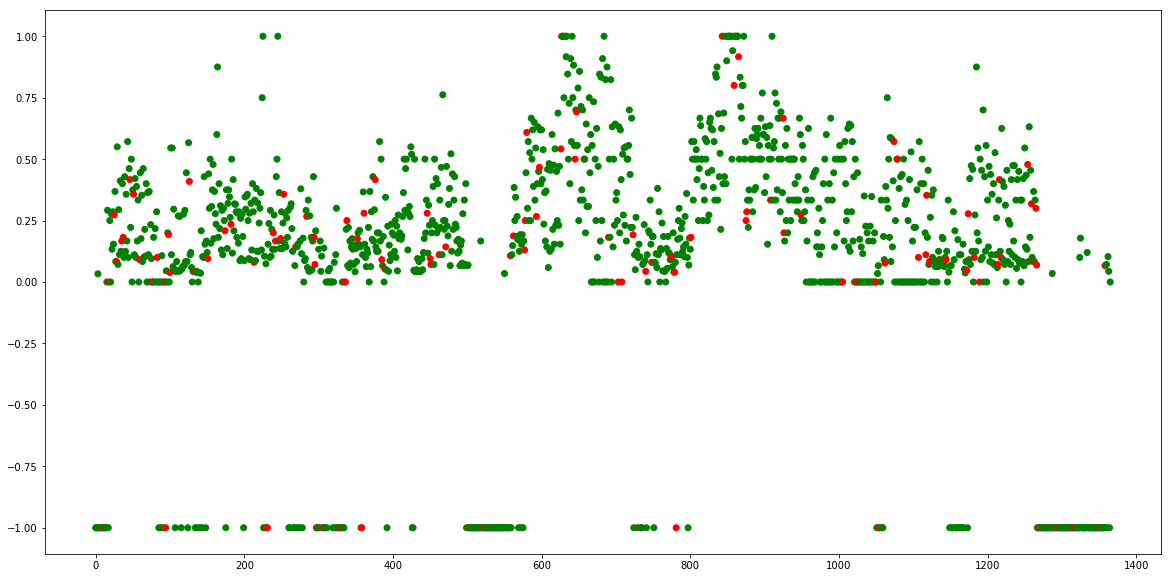

In [611]:
plotReward(len(results) - 1)

# Env class with enumerator

In [28]:
class Env(object):
    def __init__(self, df, pickIp, normalUsers, windowSize, maxLoad):
        self.df = df
        self.pickIp = pickIp
        self.normalUsers = normalUsers
        self.windowSize = windowSize
        self.maxLoad = maxLoad
        self.fv = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4] for i in range(len(pickIp))]
        self.state = [[-1]*6 for i in range(len(pickIp))]
        
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
        self.ipToIndex = {k: v for v, k in enumerate(pickIp)}

    def reset(self):
        self.fv = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4] for i in range(len(self.pickIp))]
        self.state = [[-1]*6 for i in range(len(self.pickIp))]
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
    
    def getFlatState(self):
        flatState = [item for sublist in self.state for item in sublist]
        return flatState
    
    def diffSec(self, str1, str2):
        return (dt.datetime.strptime(str1, "%H:%M:%S") - dt.datetime.strptime(str2, "%H:%M:%S")).total_seconds()
    
    def step(self, action):
    
        blockList = []
        for i in range(len(action)):
            if action[i] == 0:
                blockList.append(i)

        startTime = self.df.iloc[[self.temp_id]]['time'].values[0]
        normalNum = 0
        total = 0

        flag = True

        while True:

            if flag:
                row_id, row = self.temp_id, self.temp_row
                flag = False
            else:
                row_id, row = next(self.enu_df)

            row_ip = row[0]
            row_size = row[2]
            row_time = row[3]

            if int(self.diffSec(row_time,startTime)) == self.windowSize:

                self.temp_id, self.temp_row = row_id, row

                self.computeState(row_time)

                if total > self.maxLoad:
                    reward = -1
                else:
                    if total == 0:
                        reward = 0
                    else:
                        reward = normalNum/total
                return reward

            if row_ip in blockList:
                continue
            elif row_ip in [self.ipToIndex[ip] for ip in self.normalUsers]:
                normalNum += 1

            total += 1

            npq = self.fv[row_ip][0]
            mtq = self.fv[row_ip][1]
            psl = self.fv[row_ip][2]

            #Update number of packet queue
            if len(npq) == 0: 
                npq.append(1)
            elif mtq[len(mtq) - 1] != row_time:
                for i in range(int(self.diffSec(row_time, mtq[len(mtq) - 1])) - 1):
                    npq.append(0)
                npq.append(1)
            else:
                npq[len(npq) - 1] += 1

            #Update mean time interval queue
            self.fv[row_ip][1].append(row_time)

            #Update packet size list
            if psl[0] == -1:
                for i in range(3):
                    psl[i] = row_size
                psl[3] = 1
            else:
                psl[2] = (psl[2]*psl[3] + row_size)/(psl[3] + 1)
                psl[3] += 1

                if row_size > psl[0]:
                    psl[0] = row_size
                if row_size < psl[1]:
                    psl[1] = row_size
                
    def computeState(self, currentTime):
        for key in range(len(self.fv)):
            npq = self.fv[key][0]
            mtq = self.fv[key][1]
            psl = self.fv[key][2]

            if len(npq) == 10:
                self.state[key][0] = sum(list(npq))

            if len(mtq) == 11:
                tt = 0
                for i in range(len(mtq) - 1):
                    tt += self.diffSec(mtq[i + 1], mtq[i])
                self.state[key][1] = tt/10

            if len(mtq) != 0:
                self.state[key][2] = self.diffSec(currentTime, mtq[len(mtq) - 1])

            self.state[key][3] = psl[0]
            self.state[key][4] = psl[1]
            self.state[key][5] = psl[2]

In [118]:
class Env2(object):
    def __init__(self, df, pickIp, normalUsers, windowSize, maxLoad):
        self.df = df
        self.pickIp = pickIp
        self.normalUsers = normalUsers
        self.windowSize = windowSize
        self.maxLoad = maxLoad
        self.fv = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4] for i in range(len(pickIp))]
        self.state = [[-1]*6 for i in range(len(pickIp))]
        
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
        self.ipToIndex = {k: v for v, k in enumerate(pickIp)}

    def reset(self):
        self.fv = [[collections.deque(maxlen=10), collections.deque(maxlen=11), [-1]*4] for i in range(len(self.pickIp))]
        self.state = [[-1]*6 for i in range(len(self.pickIp))]
        self.enu_df = enumerate(self.df.values)
        self.temp_id, self.temp_row = next(self.enu_df)
    
    def getFlatState(self):
        flatState = [item for sublist in self.state for item in sublist]
        return flatState
    
    def diffSec(self, str1, str2):
        return (dt.datetime.strptime(str1, "%H:%M:%S") - dt.datetime.strptime(str2, "%H:%M:%S")).total_seconds()
    
    def step(self, action):
    
        blockList = []
        for i in range(len(action)):
            if action[i] == 0:
                blockList.append(i)

        startTime = self.df.iloc[[self.temp_id]]['time'].values[0]
        normalNum = 0
        total = 0
        
        flag = True

        while True:

            if flag:
                row_id, row = self.temp_id, self.temp_row
                flag = False
            else:
                row_id, row = next(self.enu_df)

            row_ip = row[0]
            row_size = row[2]
            row_time = row[3]

            if int(self.diffSec(row_time,startTime)) == self.windowSize:

                self.temp_id, self.temp_row = row_id, row

                self.computeState(row_time)

                if total > self.maxLoad:
                    reward = -1
                else:
                    if total == 0:
                        reward = 0
                    else:
                        reward = normalNum/total
                return reward

            if row_ip in [self.ipToIndex[ip] for ip in self.normalUsers]:
                total += 1
                if row_ip not in blockList:
                    normalNum += 1
                

            npq = self.fv[row_ip][0]
            mtq = self.fv[row_ip][1]
            psl = self.fv[row_ip][2]

            #Update number of packet queue
            if len(npq) == 0: 
                npq.append(1)
            elif mtq[len(mtq) - 1] != row_time:
                for i in range(int(self.diffSec(row_time, mtq[len(mtq) - 1])) - 1):
                    npq.append(0)
                npq.append(1)
            else:
                npq[len(npq) - 1] += 1

            #Update mean time interval queue
            self.fv[row_ip][1].append(row_time)

            #Update packet size list
            if psl[0] == -1:
                for i in range(3):
                    psl[i] = row_size
                psl[3] = 1
            else:
                psl[2] = (psl[2]*psl[3] + row_size)/(psl[3] + 1)
                psl[3] += 1

                if row_size > psl[0]:
                    psl[0] = row_size
                if row_size < psl[1]:
                    psl[1] = row_size
                
    def computeState(self, currentTime):
        for key in range(len(self.fv)):
            npq = self.fv[key][0]
            mtq = self.fv[key][1]
            psl = self.fv[key][2]

            if len(npq) == 10:
                self.state[key][0] = sum(list(npq))

            if len(mtq) == 11:
                tt = 0
                for i in range(len(mtq) - 1):
                    tt += self.diffSec(mtq[i + 1], mtq[i])
                self.state[key][1] = tt/10

            if len(mtq) != 0:
                self.state[key][2] = self.diffSec(currentTime, mtq[len(mtq) - 1])

            self.state[key][3] = psl[0]
            self.state[key][4] = psl[1]
            self.state[key][5] = psl[2]

In [121]:
allip = list(set(df2['ip']))

In [128]:
env2 = Env2(df7, allip, pickIp2, 1, 90)

In [134]:
env2.step([1]*len(allip))
env2.state

[[-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1],
 

In [125]:
df5.head()

ip  one     size      time
0   4    1  80251.0  00:00:00
1  15    1   1470.0  00:00:00
2  15    1   1696.0  00:00:00
3  15    1   2878.0  00:00:00
4  15    1   3539.0  00:00:00

In [126]:
df2.head()

ip  one     size      time
0  101.81.133.jja    1  80251.0  00:00:00
1   107.23.85.jfd    1   2825.0  00:00:00
2   107.23.85.jfd    1   3021.0  00:00:00
3   107.23.85.jfd    1   2952.0  00:00:00
4   107.23.85.jfd    1   3061.0  00:00:00

# DQN for DDoS

In [228]:
#initialize parameters
windowSize = 1
maxLoad = 30
actionNum = 10
actions = {}
for i in range(actionNum - 2):
    actions[i] = np.random.choice([0, 1], size=(18,), p=[2./3, 1./3])
actions[actionNum - 2] = [0]*12 + [1]*6
actions[actionNum - 1] = [1]*6 + [0]*12

In [229]:
actions

{0: array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]),
 1: array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 2: array([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 3: array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]),
 4: array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]),
 5: array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
 6: array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 7: array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]),
 8: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 9: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [290]:
env = Env(dff5, pickIp2, normalUsers, windowSize, maxLoad)
env.step([1]*18)

-1

In [294]:
env = Env(df5, pickIp, normalUsers, windowSize, maxLoad)
env.step([1]*18)

-1

In [295]:
# Environment parameters
n_actions = len(actions)
n_states = len(pickIp)*6

# Hyper parameters
n_hidden = 1000
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0               # reward discount factor
target_replace_iter = 100  # target network 更新間隔
memory_capacity = 2000
steps = 40000

# Visualization
rewardList = []
actionList = []
exploreList = []

# 建立 DQN
#dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = env.getFlatState()
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    reward = env.step(actions[action])
    ns = env.getFlatState()
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)

    if step % 1000 == 0:
        print(action, reward)

8 -1
9 1.0
8 -1
8 -1
8 0.0
8 -1
8 -1
8 -1
8 -1
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
0 0.06896551724137931
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
3 0.15789473684210525
9 1.0
9 1.0
9 1.0
5 0.3333333333333333
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0
9 1.0


In [296]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

In [ ]:
# 1 0630 2 0630 3 0629
# 4 0630 5 0630 6 0629 7 0630 (different action)
# 9 0630 10 0630 11 0629 12 0630 (same normal user)

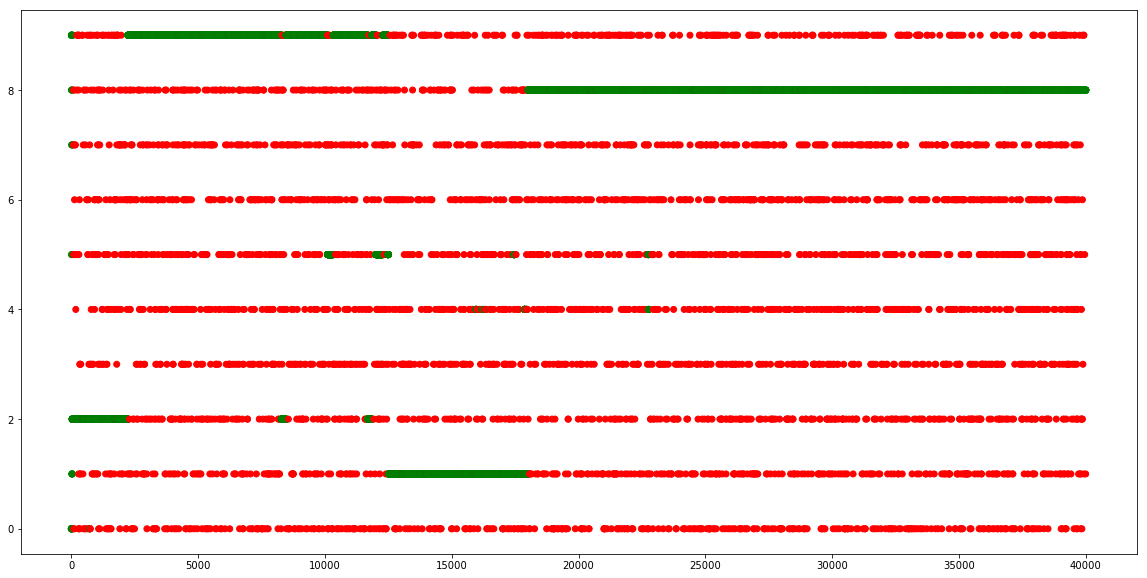

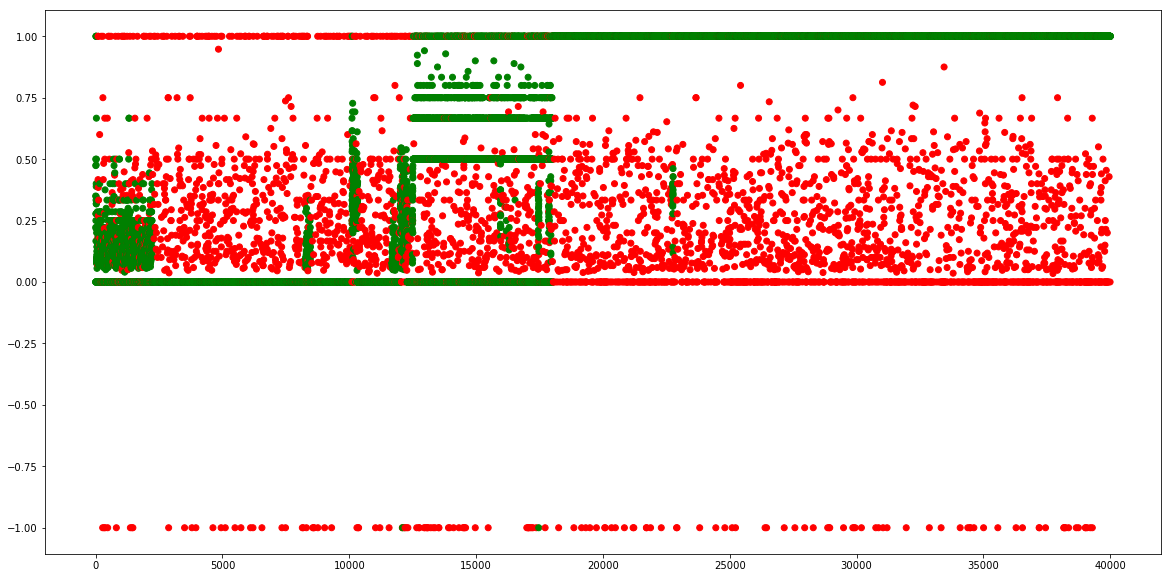

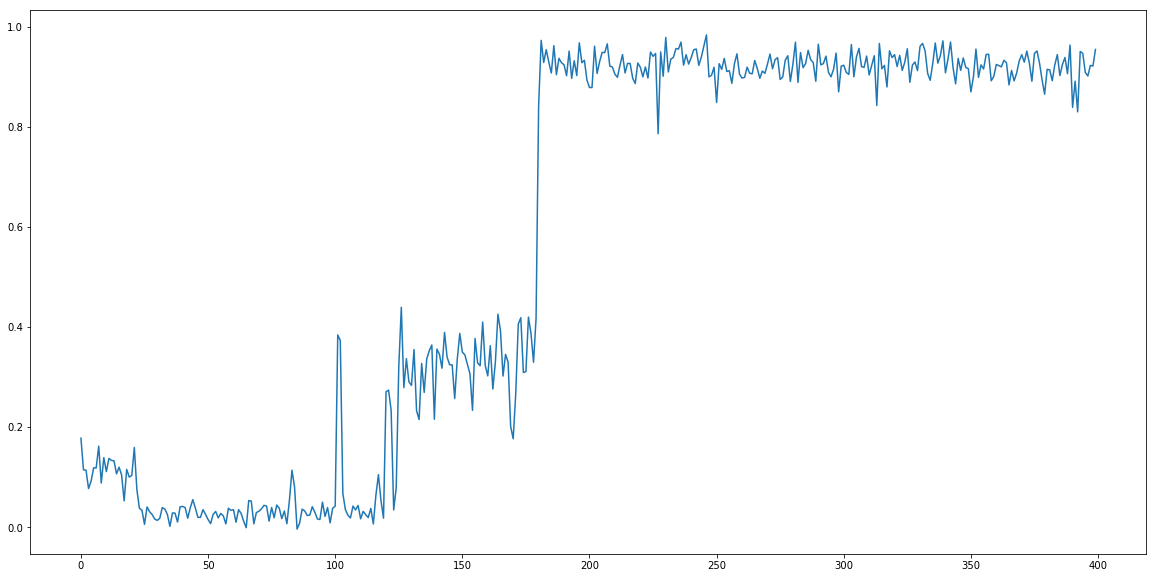

In [309]:
pltID = 11
plotAction(pltID)
plotReward(pltID)
plotRewardLine(pltID)

# DPG for DDoS

In [221]:
#initialize parameters
windowSize = 1
maxLoad = 30

env = Env(df5, pickIp, normalUsers, windowSize, maxLoad)

In [222]:
env.step([1]*18)

-1

In [223]:
# Environment parameters
n_actions = len(pickIp)
n_states = len(pickIp)*6

# Hyper parameters
n_hidden1 = 1000
n_hidden2 = 1500
batch_size = 5
lr = 0.01                 # learning rate
gamma = 0.99               # reward discount factor
steps = 20000

# Visualization
rewardList = []
actionList = []

# 建立 DQN
dpg = DPGm(n_states, n_actions, n_hidden1, n_hidden2, lr, gamma)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = env.getFlatState()
    action = dpg.choose_action(s)
    
    # 執行 action
    reward = env.step(action)
    ns = env.getFlatState()
    
    # 儲存 experience
    dpg.store_transition(s, action, reward)

    # 有足夠 experience 後進行訓練
    if step % batch_size == 0:
        dpg.learn()
    
    rewardList.append(reward)
    actionList.append(action)

    if step % 100 == 0:
        print(reward)

-1
-1
0.35
0.38095238095238093
0.25
0.25
0.4
-1
0.14285714285714285
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0.13793103448275862
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0.034482758620689655
0.27586206896551724
-1
0.2
0.2222222222222222
-1
0.13333333333333333
-1
0.16666666666666666
0.16
-1
-1
0.17391304347826086
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


KeyboardInterrupt: 

In [224]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

In [228]:
index = 4

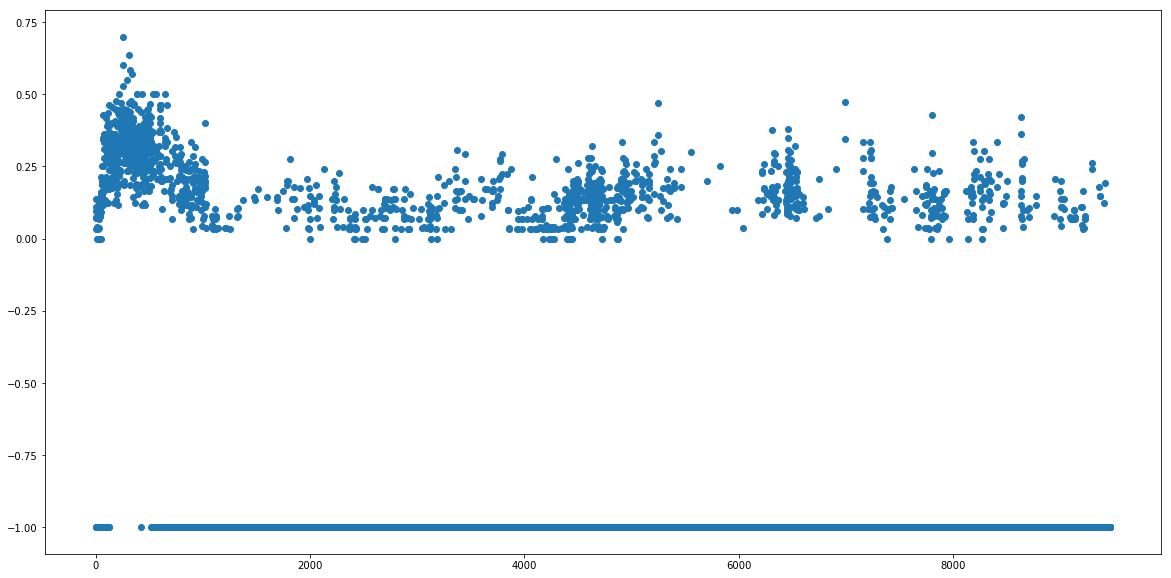

In [229]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(results[index][0])), results[index][0])
plt.show()

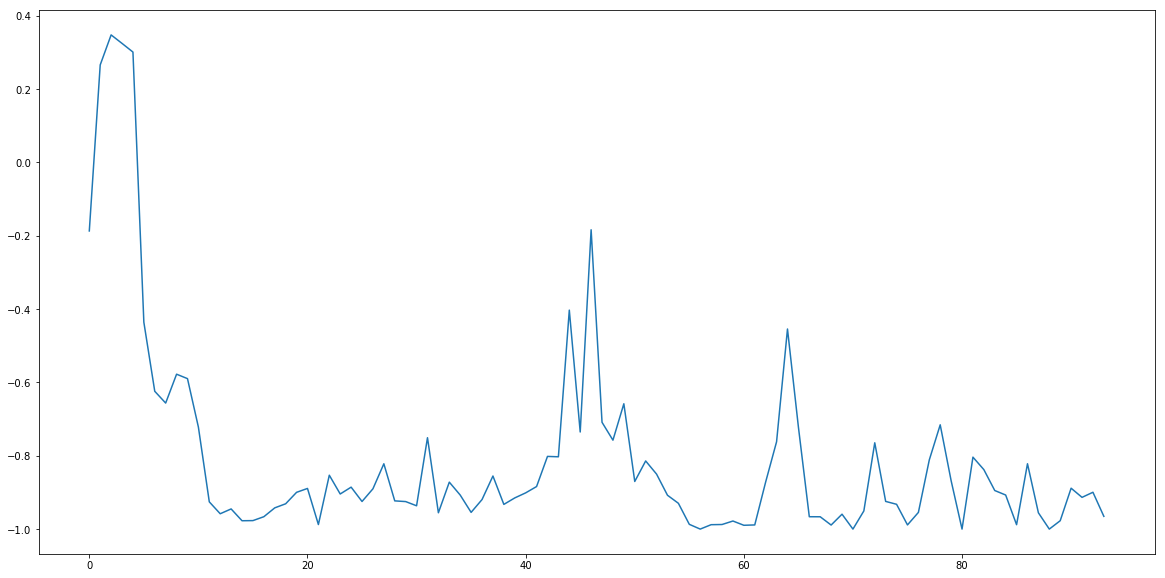

In [230]:
rewardLine = []
count = 0
aggre = 0
for i in range(len(results[index][1])):
    if True:
        count += 1
        aggre += results[index][0][i]
        if count == 100:
            rewardLine.append(aggre / 100)
            aggre = 0
            count = 0
plt.figure(figsize=(20,10))
plt.plot(rewardLine)
plt.show()

In [231]:
results[index][1][-10:]

[[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]]

# DPG for DDoS (block list as state)

In [29]:
#initialize parameters
windowSize = 1
maxLoad = 30

env = Env(df5, pickIp, normalUsers, windowSize, maxLoad)

In [30]:
env.step([1]*18)

-1

In [31]:
# Environment parameters
n_actions = len(pickIp)
n_states = len(pickIp)

# Hyper parameters
n_hidden1 = 1000
n_hidden2 = 1500
batch_size = 100
lr = 0.01                 # learning rate
gamma = 0.99               # reward discount factor
steps = 20000

# Visualization
rewardList = []
actionList = []

# 建立 DQN
dpg = DPGm(n_states, n_actions, n_hidden1, n_hidden2, lr, gamma)

blstate = [1]*len(pickIp)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = blstate
    action = dpg.choose_action(s)
    
    # 執行 action
    reward = env.step(action)
    blstate = action
    
    # 儲存 experience
    dpg.store_transition(s, action, reward)

    # 有足夠 experience 後進行訓練
    if step % batch_size == 0:
        dpg.learn()
    
    rewardList.append(reward)
    actionList.append(action)

    if step % 1000 == 0:
        print(reward)

-1
-1
-1
-1
0.1724137931034483
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [32]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)

In [33]:
index = 0

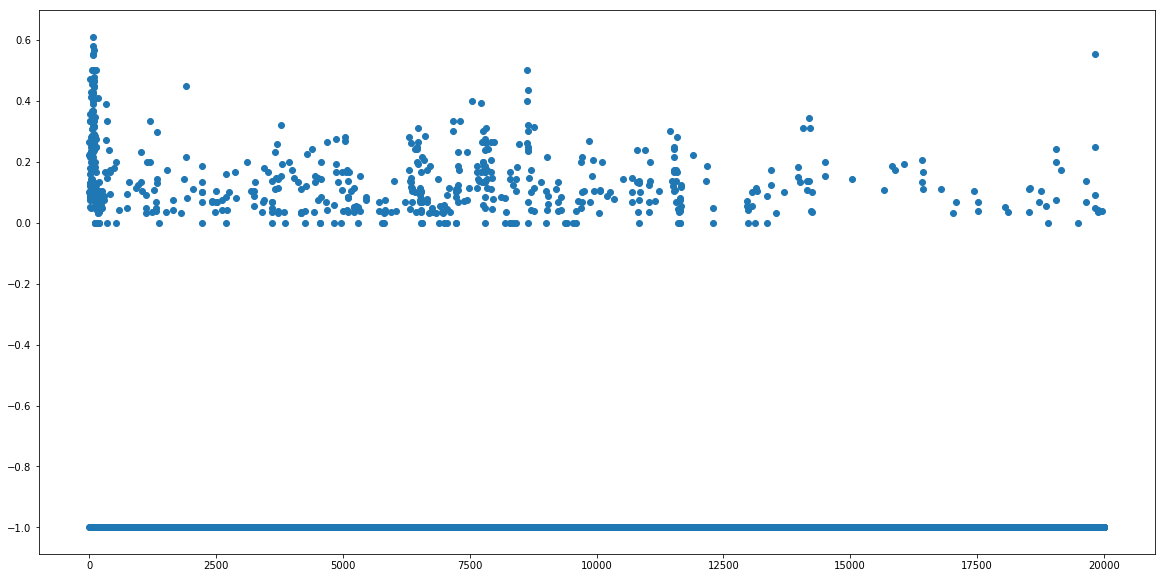

In [34]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(results[index][0])), results[index][0])
plt.show()

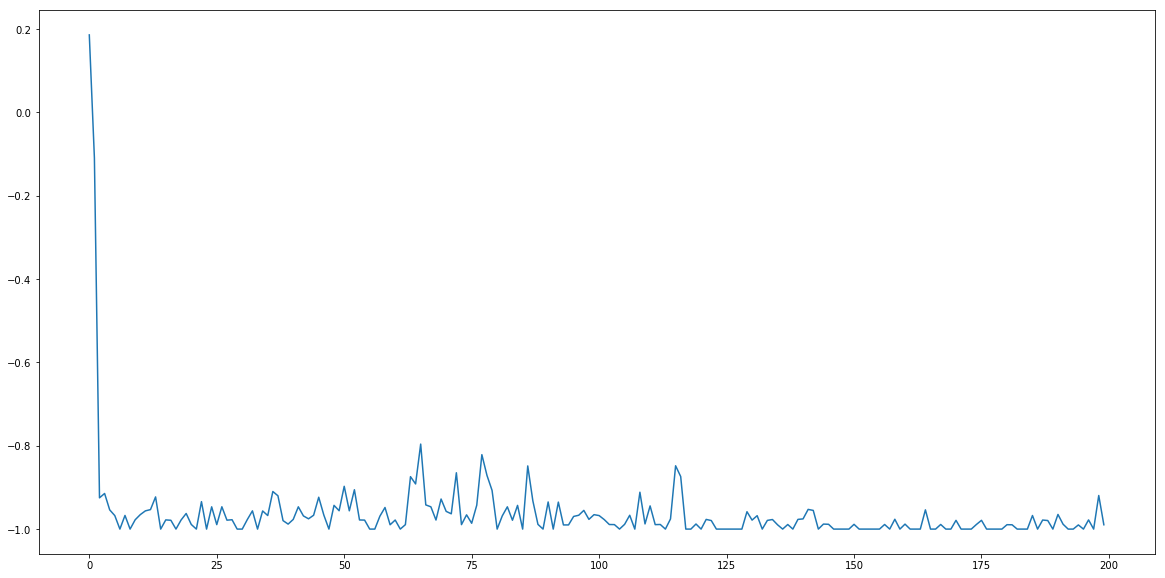

In [35]:
rewardLine = []
count = 0
aggre = 0
for i in range(len(results[index][1])):
    if True:
        count += 1
        aggre += results[index][0][i]
        if count == 100:
            rewardLine.append(aggre / 100)
            aggre = 0
            count = 0
plt.figure(figsize=(20,10))
plt.plot(rewardLine)
plt.show()

# DQN for DDoS (block list as state)

In [789]:
def envStepFastLwoF(stateID, action):
    
    blockList = []
    for i in range(len(action)):
        if action[i] == 0:
            blockList.append(i)
            
    startTime = df5.iloc[[stateID]]['time'].values[0]
    normalNum = 0
    normalTotal = 0
    total = 0
    
    for row in islice(df5.itertuples(), stateID, None):
        
        if int(diffSec(getattr(row, 'time'),startTime)) == windowSize:
            
            if total > maxLoad:
                reward = -1
            else:
                if total == 0:
                    print('no packet!')
                    reward = 0
                else:
                    if False:#normalTotal == 0:
                        reward = 0
                    else:
                        reward = normalNum/total
            return getattr(row, 'Index'), reward
        
        if getattr(row, 'ip') in blockList:
            if getattr(row, 'ip') in [ipToIndex[ip] for ip in normalUsers]:
                normalTotal += 1
            continue
        elif getattr(row, 'ip') in [ipToIndex[ip] for ip in normalUsers]:
            normalNum += 1
            normalTotal += 1
        
        total += 1

In [790]:
#initialize parameters
windowSize = 1
maxLoad = 30

#initialize state
QwoFstate = [1]*len(pickIp)

In [791]:
stateID, r = envStepFastLwoF(0, QwoFstate)

In [792]:
# Environment parameters
n_actions = len(pickIp) + 1
n_states = len(pickIp)

# Hyper parameters
n_hidden = 1000
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.1             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100  # target network 更新間隔
memory_capacity = 2000
steps = 8000

# Visualization
rewardList = []
actionList = []
exploreList = []
stateList.append([])

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = QwoFstate[:]
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    if action != len(pickIp):
        QwoFstate[action] = (QwoFstate[action] + 1) % 2
    next_stateID, reward = envStepFastLwoF(stateID, QwoFstate)
    ns = QwoFstate[:]
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    stateList[len(stateList) - 1].append(QwoFstate[:])
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 50 == 0:
        print(action, reward)

3 -1
12 -1
5 0.1111111111111111
5 0.07407407407407407
5 0.09090909090909091
5 0.21739130434782608
10 0.0
10 -1
18 0.0
8 0.08333333333333333
12 -1
3 0.25925925925925924
3 0.44
10 -1
12 0.35714285714285715
10 0.3888888888888889
3 0.3333333333333333
3 0.3333333333333333
3 -1
3 0.16666666666666666
18 0.12
16 -1
6 -1
16 -1
12 0.17647058823529413
14 0.4444444444444444
11 -1
5 0.6
no packet!
3 0.0
no packet!
no packet!
2 -1
18 -1
2 0.0
2 0.5714285714285714
10 0.0
3 0.0
3 0.0
5 0.0
2 0.0
2 0.125
5 0.058823529411764705
2 0.0
10 0.16
7 0.36363636363636365
1 0.2
6 0.0
no packet!
no packet!
no packet!
6 1.0
7 0.5384615384615384
3 0.0
6 0.21428571428571427
16 0.8125
13 0.17391304347826086
15 0.5384615384615384
15 0.5384615384615384
7 0.21428571428571427
6 0.36363636363636365
0 0.5384615384615384
6 0.5555555555555556
14 0.6428571428571429
14 0.6363636363636364
6 0.5
15 0.8
4 0.6428571428571429
17 0.6666666666666666
5 1.0
3 0.4
1 0.75
18 0.8666666666666667
15 0.4
18 0.36363636363636365
18 0.75
15 0.8

In [793]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

In [729]:
def plotState(sl, st = 0):
    st *= len(pickIp)
    ed = st + 50*len(pickIp)
    
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(sl)) for j in range(len(pickIp))]
    y = [j for i in range(len(sl)) for j in range(len(pickIp))]
    flat = [item + 2 for sublist in sl for item in sublist]
    plt.scatter(x[st:ed], y[st:ed], color = list(map(toColor, flat))[st:ed], s=22**2, alpha=0.5)
    plt.show()

In [782]:
def plotRewardLine(index):
    rewardLine = []
    count = 0
    aggre = 0
    for i in range(len(results[index][1])):
        if results[index][2]:
            count += 1
            aggre += results[index][0][i]
            if count == 100:
                rewardLine.append(aggre / 100)
                aggre = 0
                count = 0
    plt.figure(figsize=(20,10))
    plt.plot(rewardLine)
    plt.show()

In [659]:
'''
34 - first
35 - reward = normal / max load --INTERRUPT
36 - cheat reward function (sl 3)
37 - normal reward function (sl 4)
'''

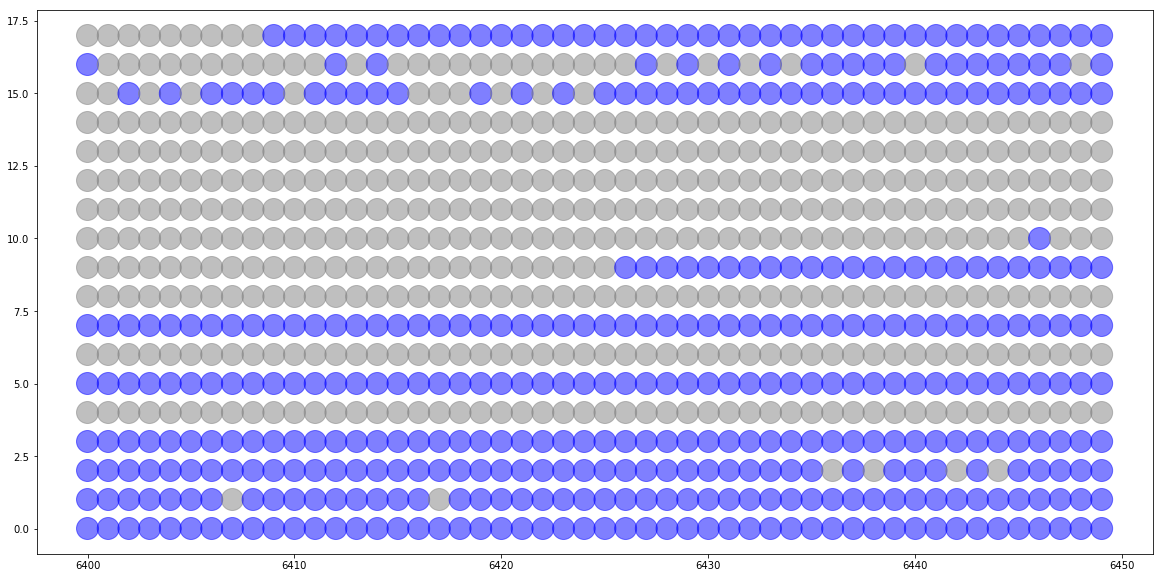

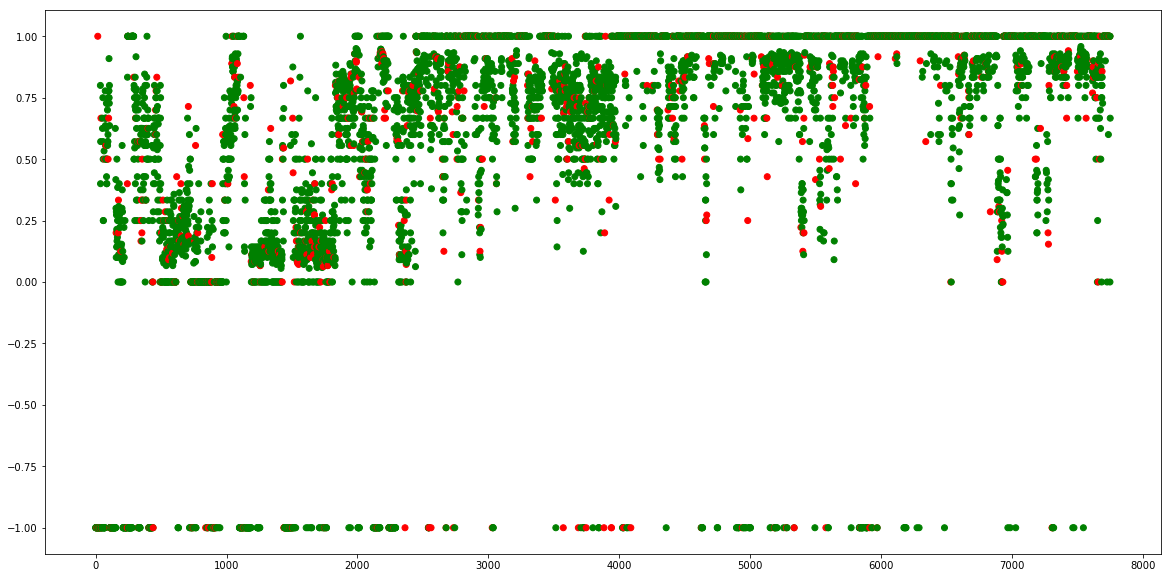

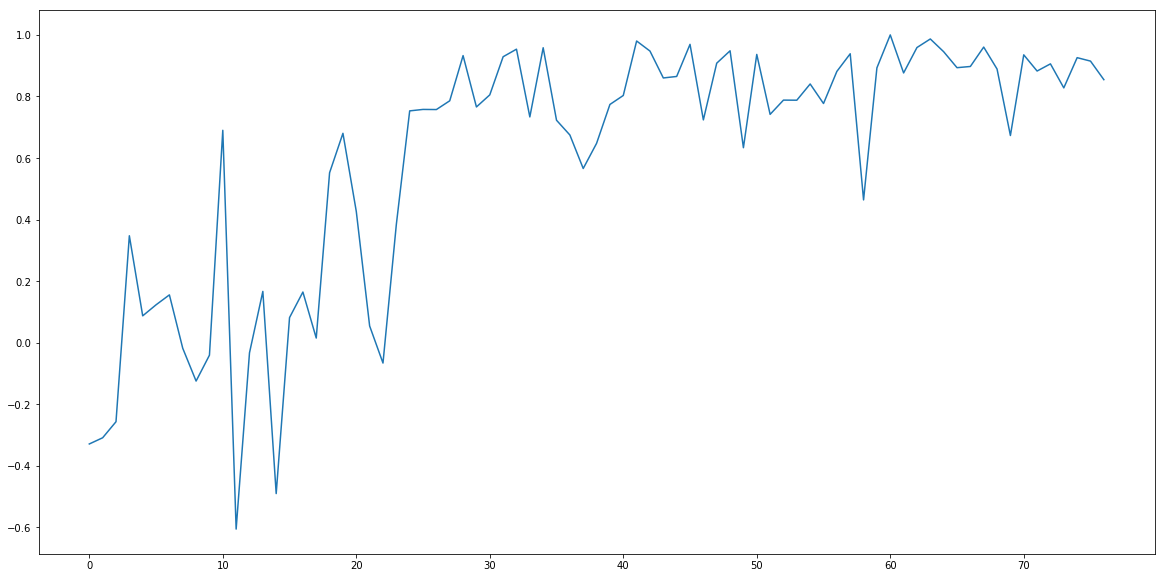

In [794]:
# 36 plot
plotState(stateList[3], 6400)
plotReward(36)
plotRewardLine(36)

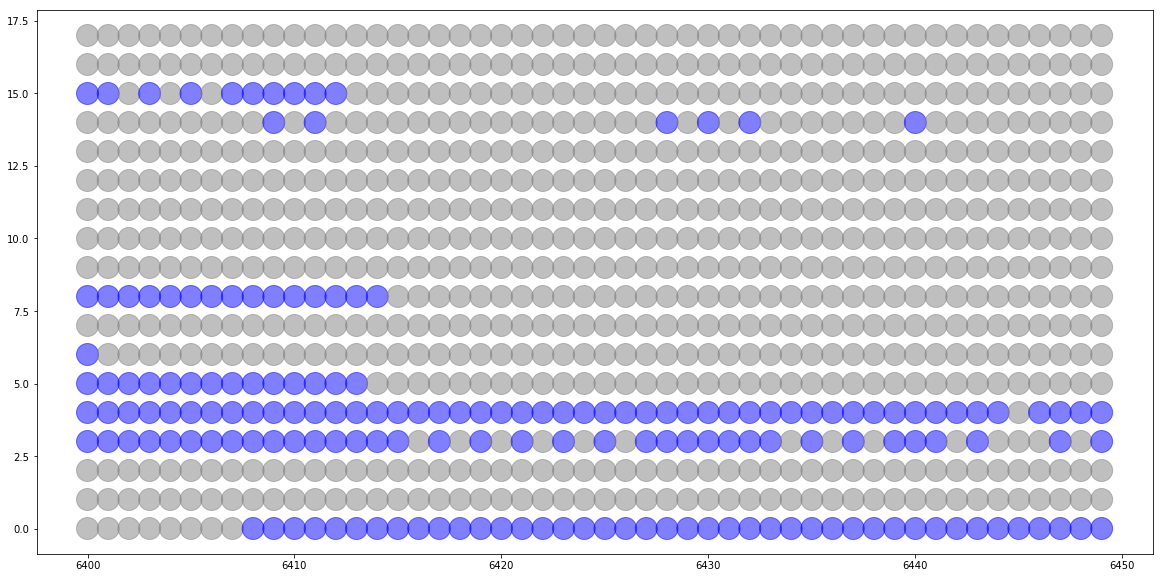

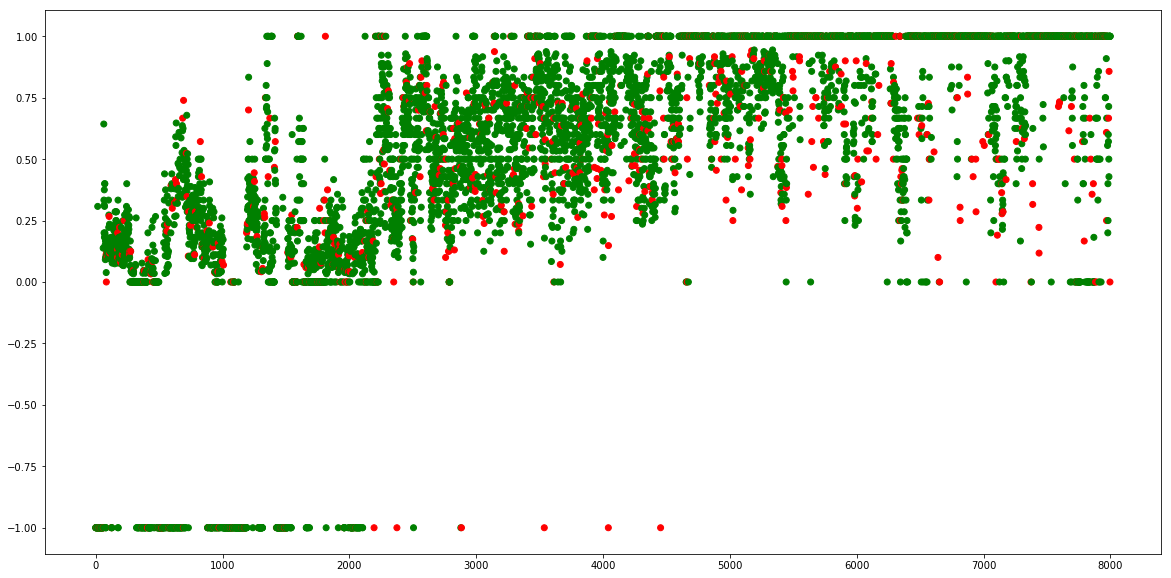

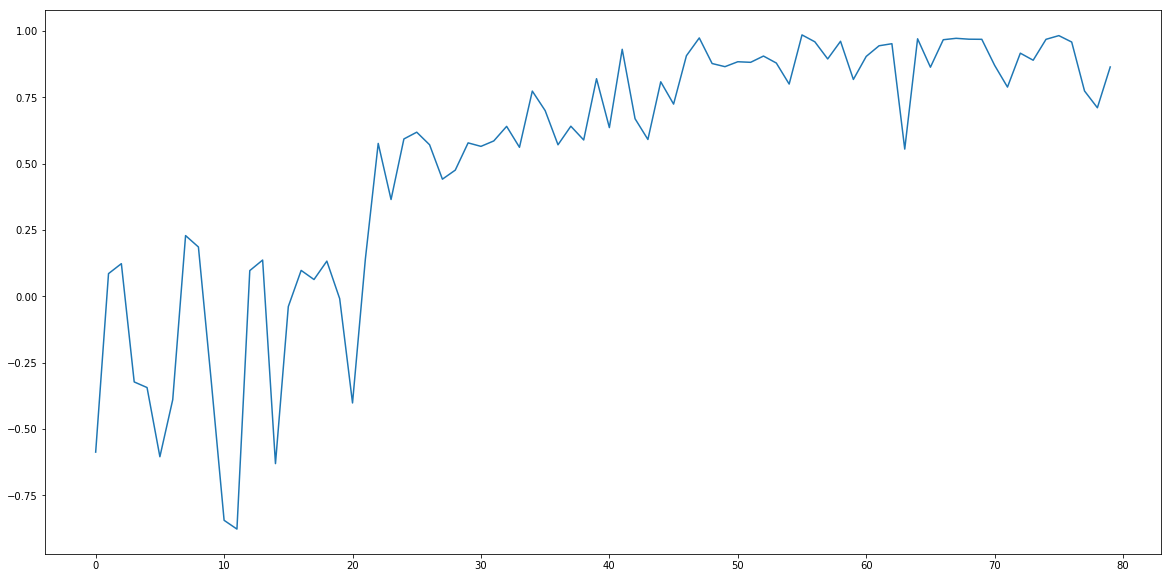

In [795]:
# 37 plot
plotState(stateList[4], 6400)
plotReward(37)
plotRewardLine(37)

# RL with VFA for DDoS (block list as state)

In [261]:
#initialize parameters
windowSize = 1
maxLoad = 30

#initialize state
QwoFstate = [1]*len(pickIp)

env = Env(df5, pickIp, normalUsers, windowSize, maxLoad)

In [262]:
env.step(QwoFstate)

-1

In [263]:
# Environment parameters
n_actions = 1
n_states = len(pickIp)

# Hyper parameters
n_hidden = 1000
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100  # target network 更新間隔
memory_capacity = 2000
steps = 20000

# Visualization
rewardList = []
actionList = []
exploreList = []
stateList.append([])

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = QwoFstate[:]
    if np.random.uniform() < epsilon: # 隨機
        action = np.random.randint(0, 19)
        explore = 1
    else:
        next_v = []
        for i in range(len(pickIp)):
            tempS = QwoFstate[:]
            tempS[i] = (tempS[i] + 1) % 2
            next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(tempS), 0)).data.numpy()[0][0]) 
        next_v.append(dqn.eval_net(torch.unsqueeze(torch.FloatTensor(s), 0)).data.numpy()[0][0])
        action = np.argmax(next_v)
        explore = 0
    
    # 執行 action
    if action != len(pickIp):
        QwoFstate[action] = (QwoFstate[action] + 1) % 2
    reward = env.step(QwoFstate)
    ns = QwoFstate[:]
    
    # 儲存 experience
    dqn.store_transition(s, 0, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    stateList[len(stateList) - 1].append(QwoFstate[:])
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 500 == 0:
        print(action, reward)

10 -1
18 -1
18 -1
18 -1
18 -1
18 1.0
18 1.0
18 1.0
18 1.0
18 1.0
18 1.0
18 1.0
18 1.0
18 1.0


KeyboardInterrupt: 

In [264]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

In [255]:
len(stateList)

7

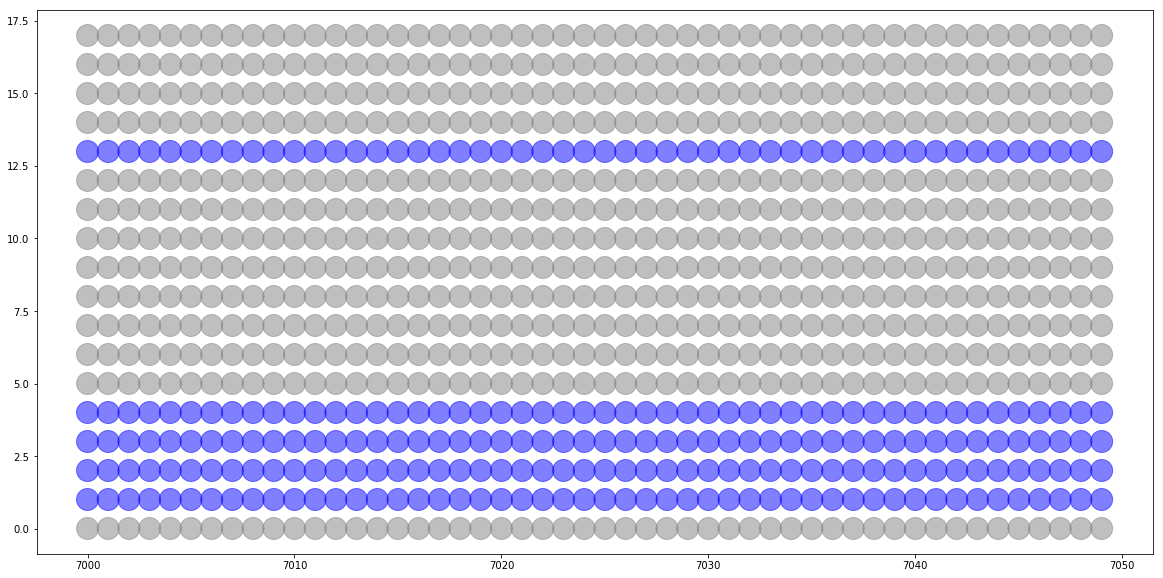

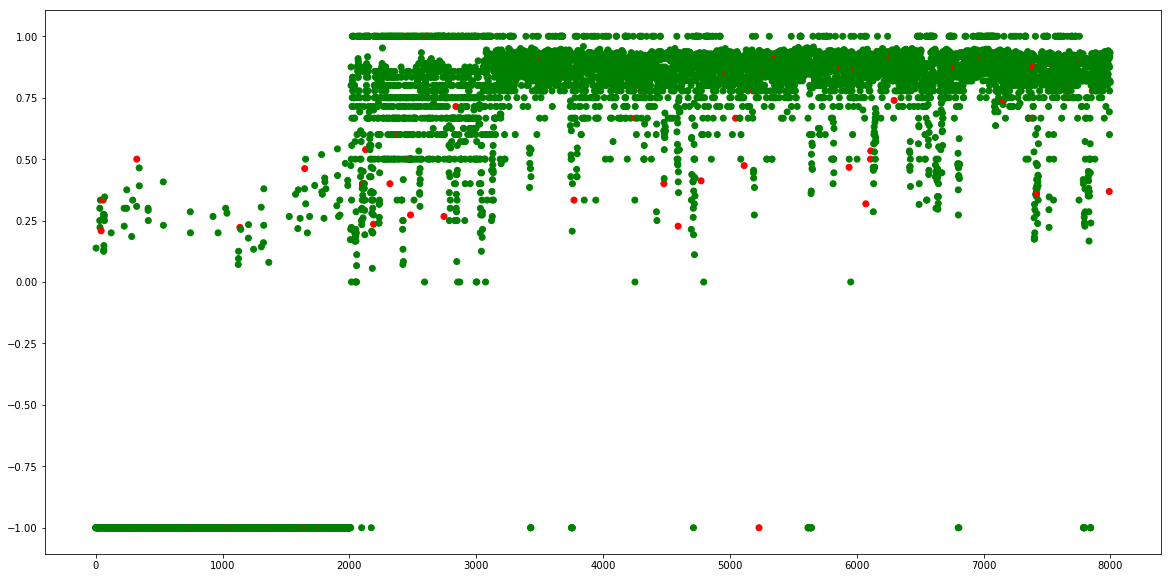

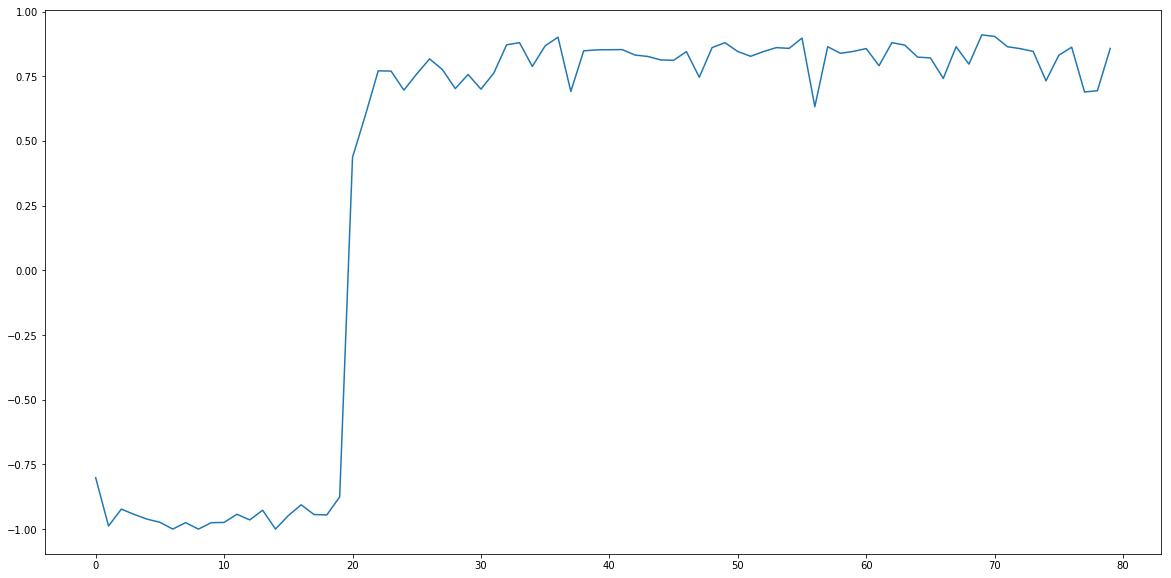

In [242]:
# plot
plotState(stateList[4], 7000)
plotReward(5)
plotRewardLine(5)

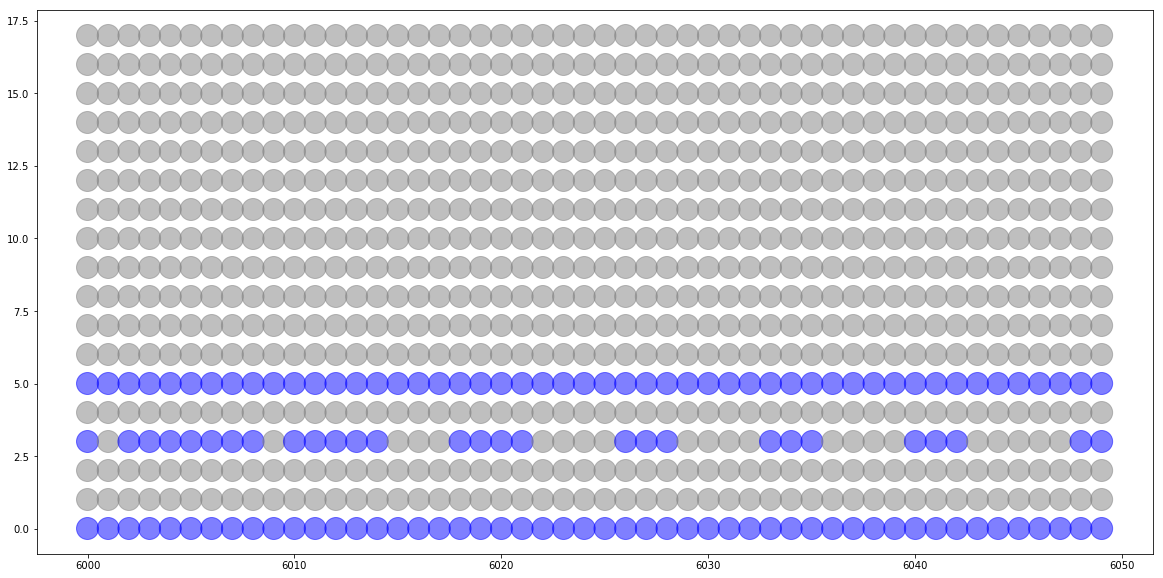

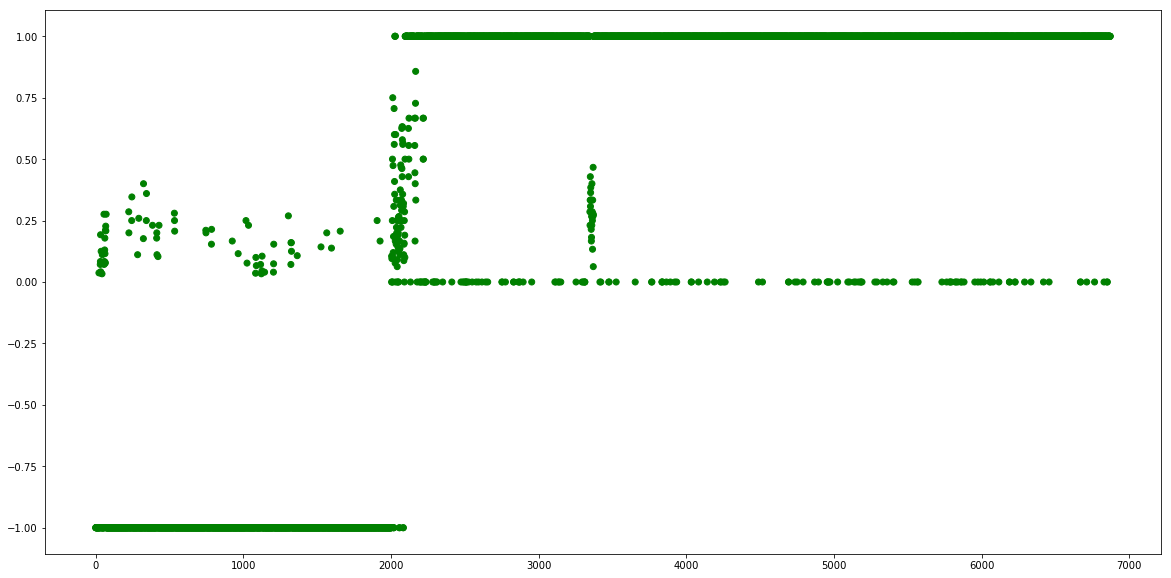

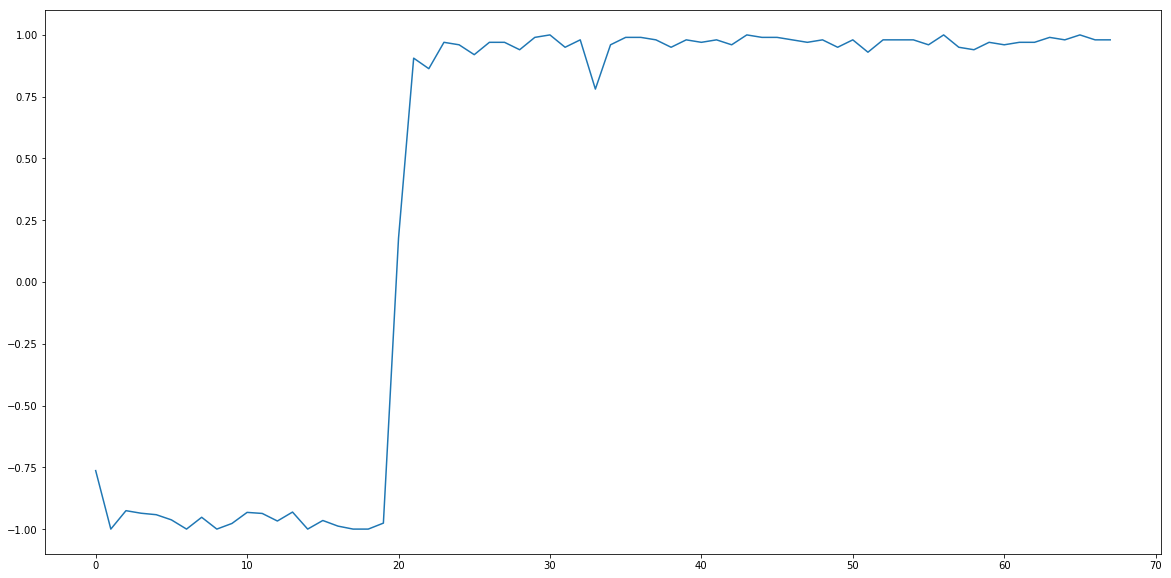

In [266]:
# plot
plotState(stateList[8], 6000)
plotReward(10)
plotRewardLine(10)

In [207]:
def plotState(sl, st = 0):
    st *= len(pickIp)
    ed = st + 50*len(pickIp)
    
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(sl)) for j in range(len(pickIp))]
    y = [j for i in range(len(sl)) for j in range(len(pickIp))]
    flat = [item + 2 for sublist in sl for item in sublist]
    plt.scatter(x[st:ed], y[st:ed], color = list(map(toColor, flat))[st:ed], s=22**2, alpha=0.5)
    plt.show()

# DQN for DDoS (block list as state) 2

In [245]:
#initialize parameters
windowSize = 1
maxLoad = 30

#initialize state
QwoFstate = [1]*len(pickIp)

env = Env(df5, pickIp, normalUsers, windowSize, maxLoad)

In [246]:
env.step(QwoFstate)

-1

In [247]:
# Environment parameters
n_actions = len(pickIp) + 1
n_states = len(pickIp)

# Hyper parameters
n_hidden = 1000
batch_size = 32
lr = 0.01                 # learning rate
epsilon = 0.01             # epsilon-greedy
gamma = 0.9               # reward discount factor
target_replace_iter = 100  # target network 更新間隔
memory_capacity = 2000
steps = 8000

# Visualization
rewardList = []
actionList = []
exploreList = []
stateList.append([])

# 建立 DQN
dqn = DQN(n_states, n_actions, n_hidden, batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity)

# 學習
for step in range(steps):
    
    # 選擇 action
    s = QwoFstate[:]
    action, explore = dqn.choose_action(s)
    
    # 執行 action
    if action != len(pickIp):
        QwoFstate[action] = (QwoFstate[action] + 1) % 2
    reward = env.step(QwoFstate)
    ns = QwoFstate[:]
    
    # 儲存 experience
    dqn.store_transition(s, action, reward, ns)

    # 有足夠 experience 後進行訓練
    if dqn.memory_counter > memory_capacity:
        dqn.learn()

    # 進入下一 state
    stateID = next_stateID
    
    rewardList.append(reward)
    actionList.append(action)
    exploreList.append(explore)
    stateList[len(stateList) - 1].append(QwoFstate[:])
    '''
    clear_output(wait=True)
    plt.plot(list(range(step - 20, step)), rewardList[-20:])
    plt.axis((step - 20, step,-1,1))
    print(action)
    plt.show()
    '''
    if step % 500 == 0:
        print(action, reward)

15 -1
3 0.35714285714285715
15 -1
15 -1
15 -1
18 0.7647058823529411
16 0.2
18 0.0
18 1.0
7 0.1
6 0.3
2 0.375
8 0.2777777777777778
8 0.4444444444444444
10 -1
7 0.2857142857142857


In [248]:
results.append([])
results[len(results) - 1].append(rewardList)
results[len(results) - 1].append(actionList)
results[len(results) - 1].append(exploreList)

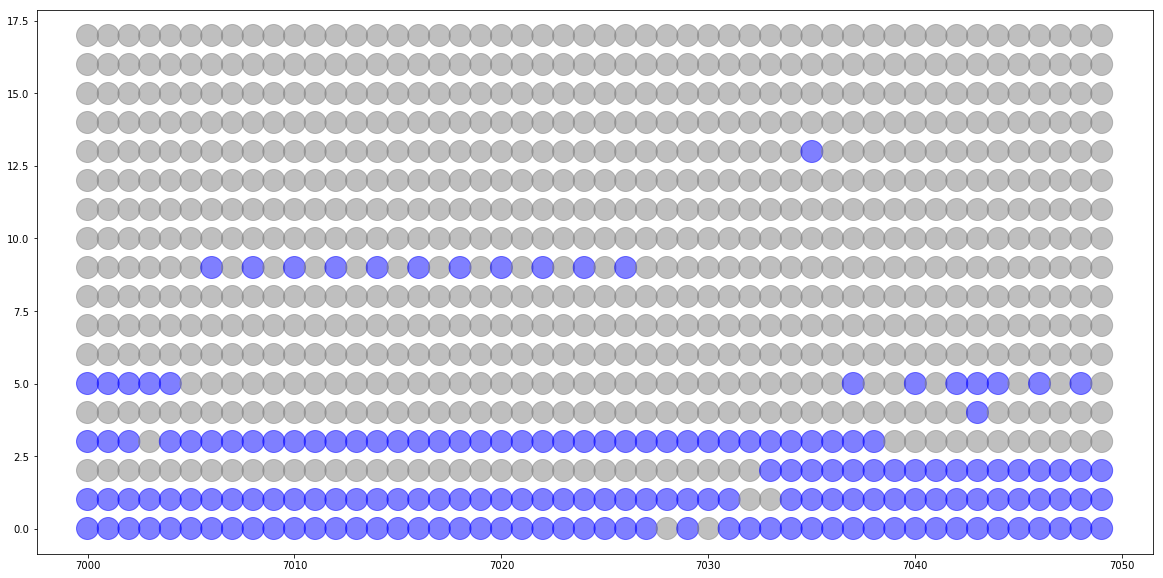

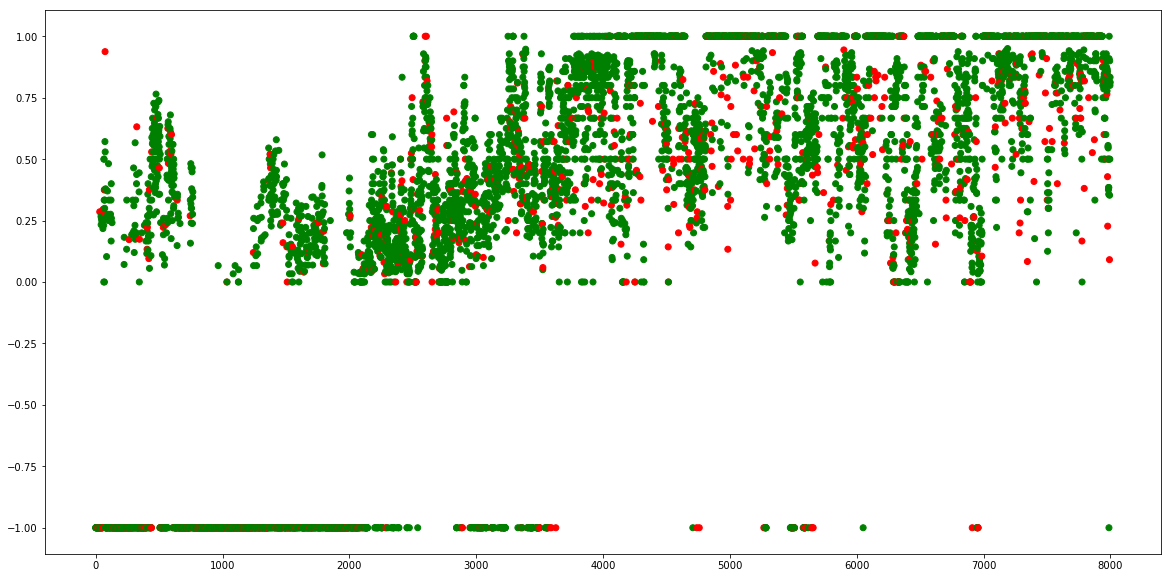

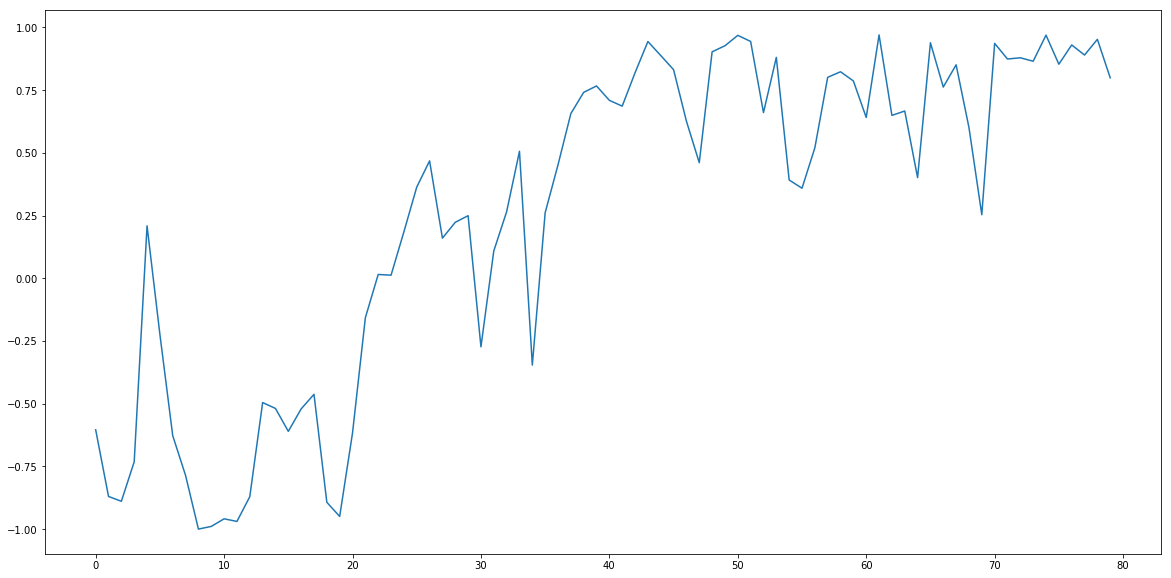

In [244]:
# plot
plotState(stateList[5], 7000)
plotReward(7)
plotRewardLine(7)

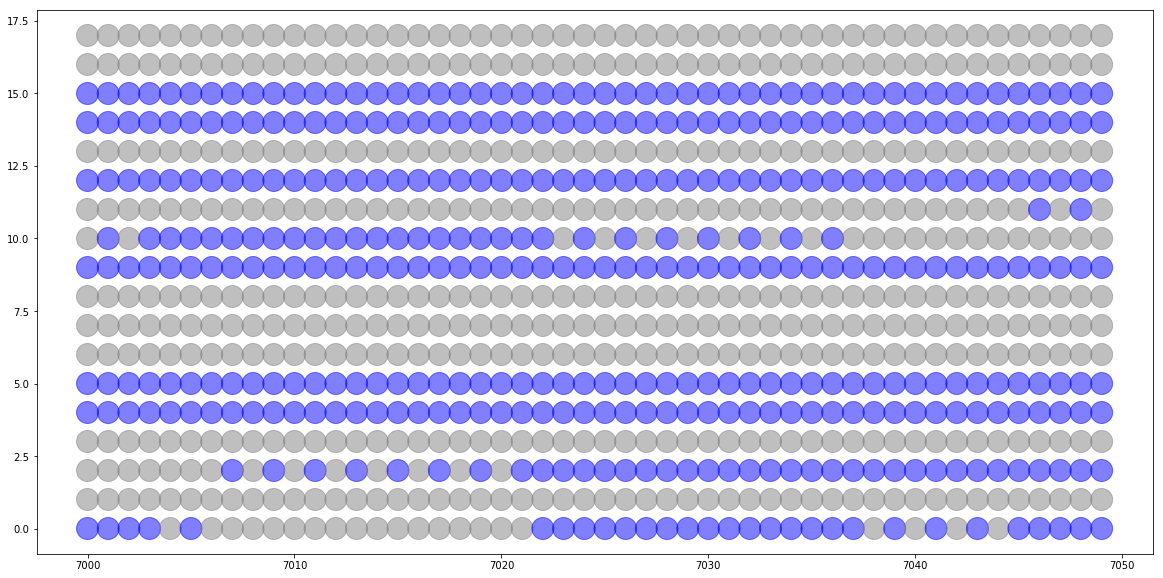

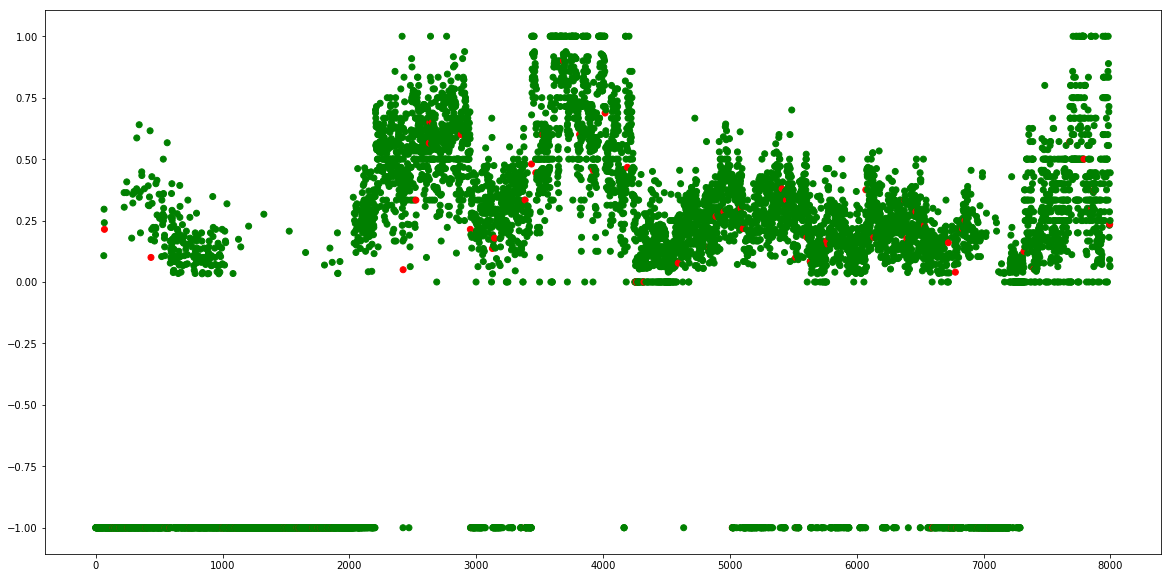

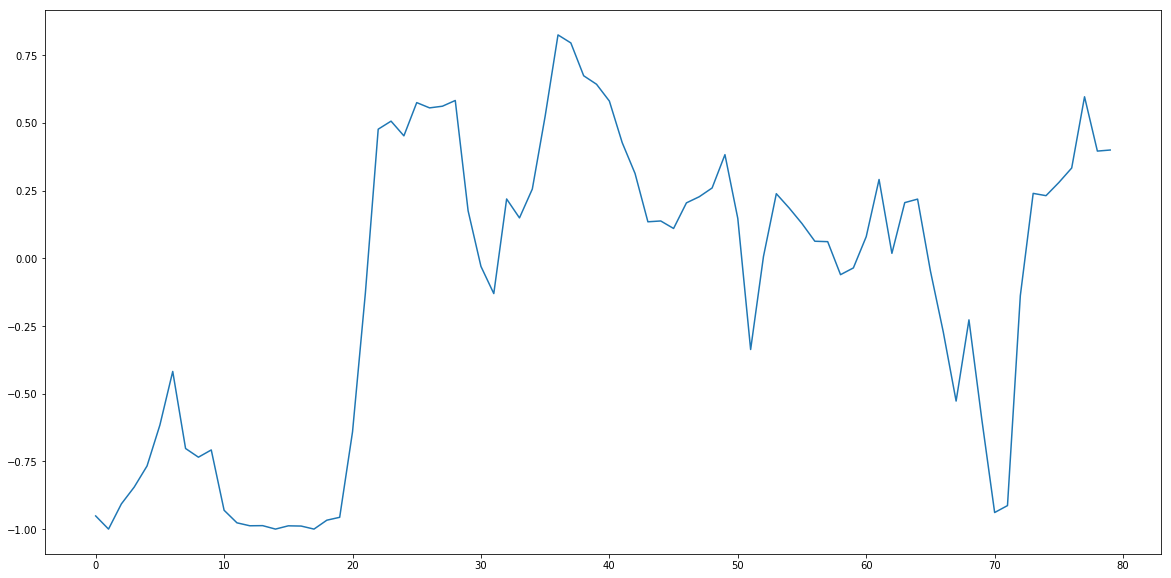

In [253]:
# plot
plotState(stateList[6], 7000)
plotReward(8)
plotRewardLine(8)